# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

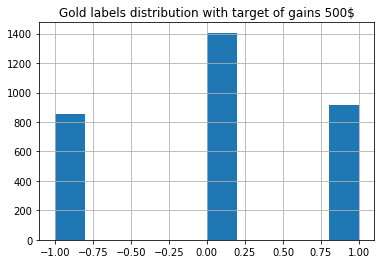

In [12]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

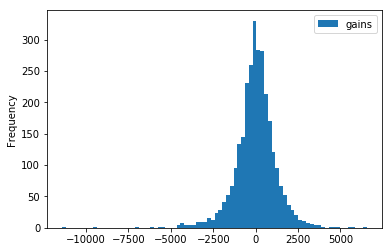

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



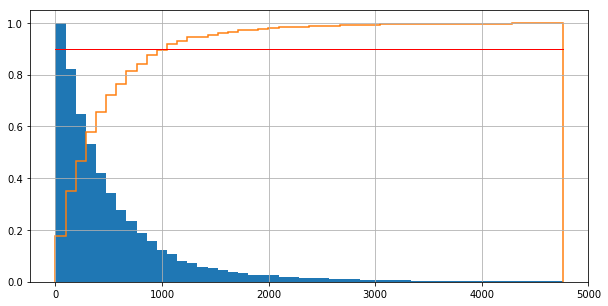

In [18]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

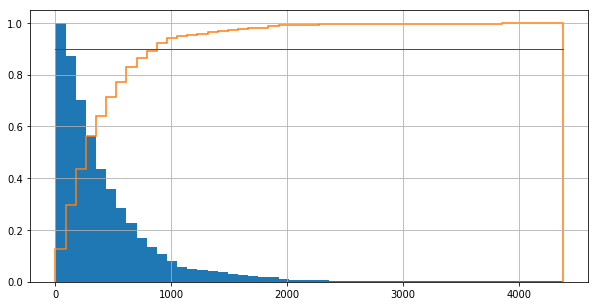

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

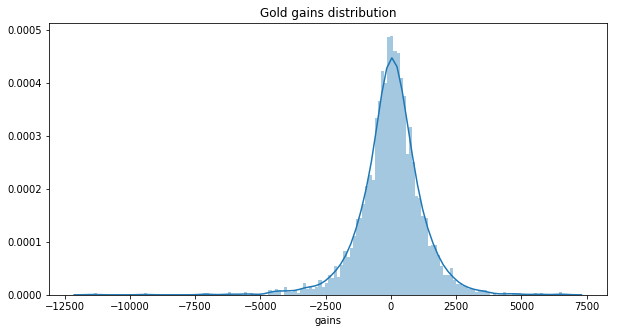

In [22]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

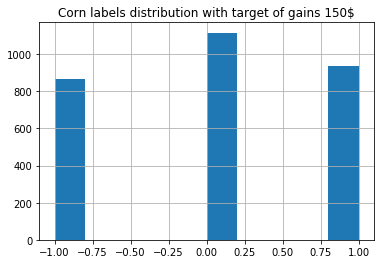

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

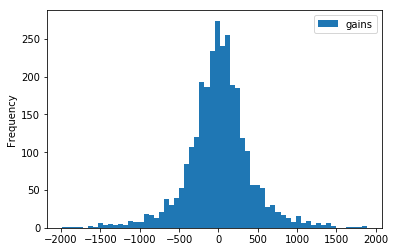

In [26]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

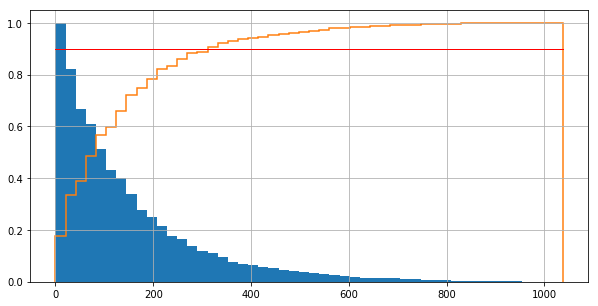

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

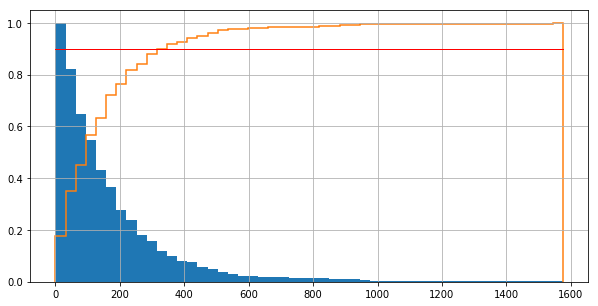

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


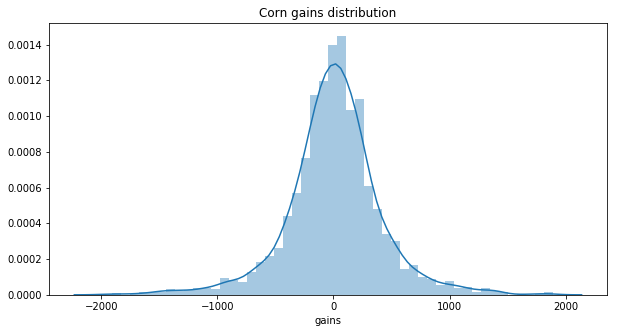

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


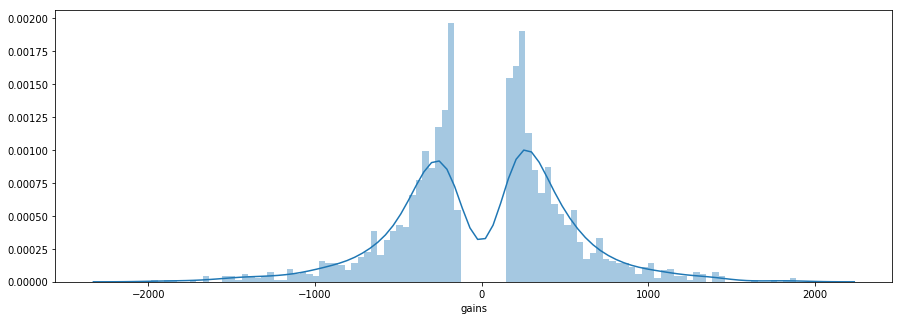

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

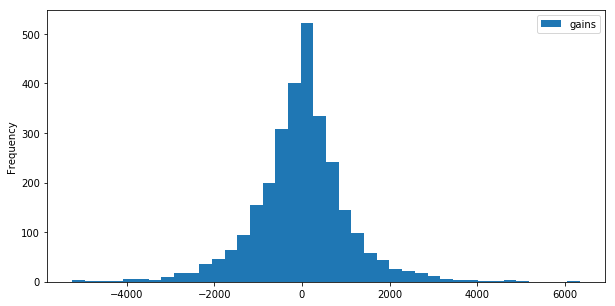

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

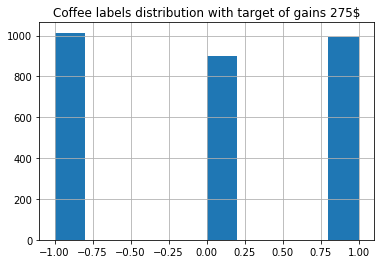

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

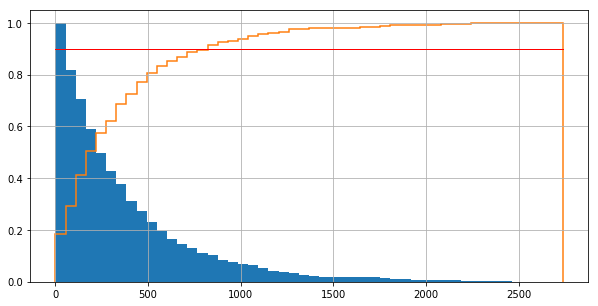

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

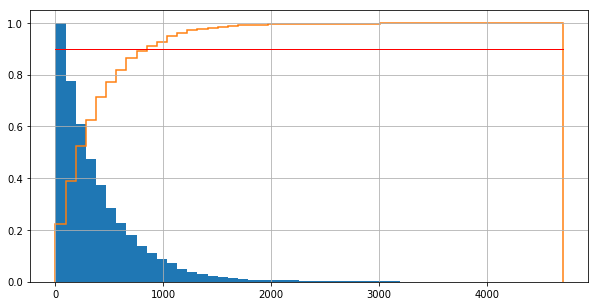

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

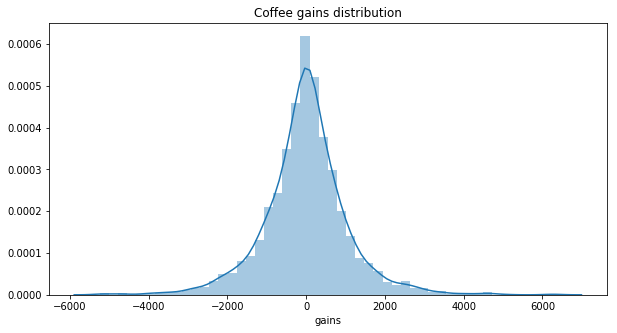

In [39]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

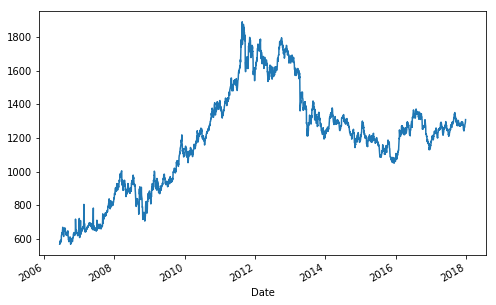

In [40]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

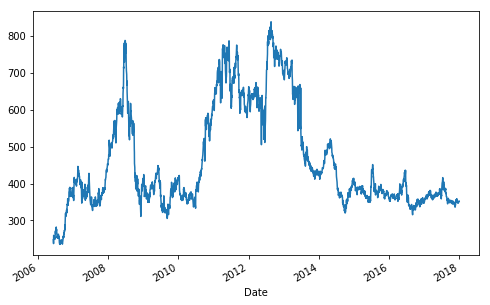

In [41]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

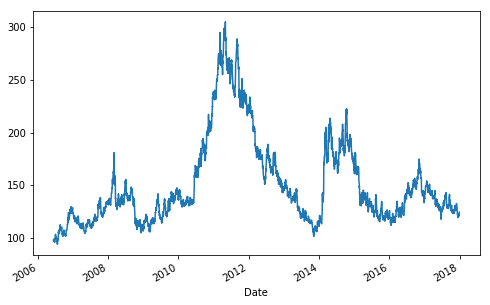

In [42]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [43]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [44]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [45]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [46]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [47]:
gold_data.shape

(2668, 2545)

In [48]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [49]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [50]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [51]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [52]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [53]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [54]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [55]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [56]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [57]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [58]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new', random_state=428)
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new', random_state=912)
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new', random_state=832)
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [59]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 6
inliers: 1927


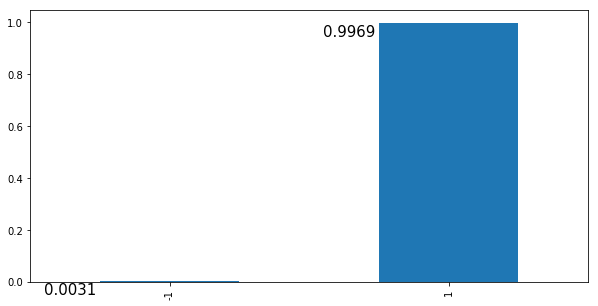

In [60]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [61]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [62]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-09-25 00:00:00
2017-11-14 00:00:00
2017-11-20 00:00:00
2017-12-05 00:00:00
2017-12-22 00:00:00
2017-12-12 00:00:00


outliers: 15
inliers: 1915


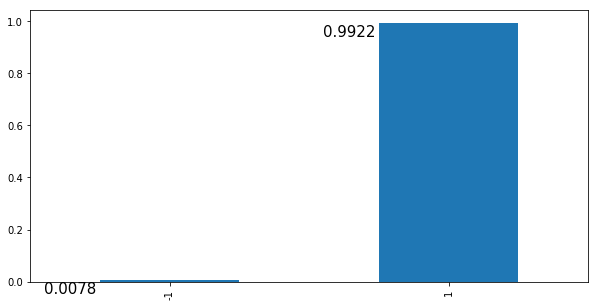

In [63]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [64]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-06-08 00:00:00
2017-09-28 00:00:00
2017-08-01 00:00:00
2017-03-24 00:00:00
2017-11-13 00:00:00
2017-09-01 00:00:00
2017-09-20 00:00:00
2017-10-30 00:00:00
2017-07-10 00:00:00
2017-06-16 00:00:00
2017-06-26 00:00:00
2017-10-10 00:00:00
2017-09-18 00:00:00
2017-11-02 00:00:00
2017-08-02 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 346
inliers: 1577


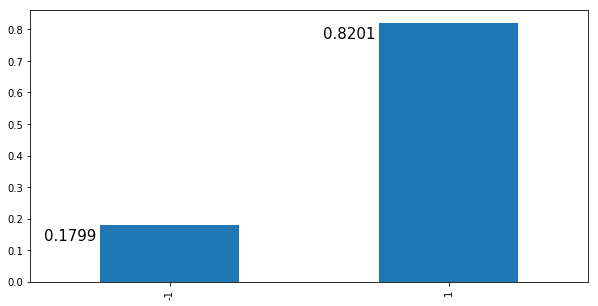

In [65]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [66]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00


In [67]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

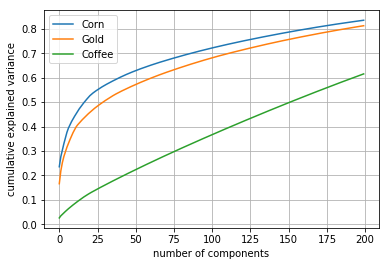

In [68]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [69]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [70]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [71]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [72]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [73]:
from numpy import size
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


def make_label(v, threshold, fee):
    if abs(v)-fee > threshold:
        if v > 0:
            return 1
        else:
            return -1
    return 0


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False, name=''):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        savefig('figures/' + name + '_kernel_density_residuals.eps')
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        savefig('figures/' + name + '_actual_prediction.eps')
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, regression, name, target)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False, name='', target=0):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    savefig('figures/' + name + '_account.eps')
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if regression:
        label = list(map(lambda x: make_label(x, target, fee), rf.label))
        # print(rf.label)
        # print(label)
    else:
        label = rf.label
    print("Precision score: ", precision_score(label, rf.trade, average=None))
    if not regression:
        # print("Precision score: ", precision_score(list(map(, rf.label)), rf.trade, average=None))
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        savefig('figures/' + name + '_heatmap.eps')
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    savefig('figures/' + name + '_trade_histogram.eps')
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [74]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[298]	valid_0's l2: 1.62219e+06
[299]	valid_0's l2: 1.62223e+06
[300]	valid_0's l2: 1.62221e+06
[301]	valid_0's l2: 1.62218e+06
[302]	valid_0's l2: 1.62224e+06
[303]	valid_0's l2: 1.62222e+06
[304]	valid_0's l2: 1.62219e+06
[305]	valid_0's l2: 1.62217e+06
[306]	valid_0's l2: 1.62215e+06
[307]	valid_0's l2: 1.62213e+06
[308]	valid_0's l2: 1.62218e+06
[309]	valid_0's l2: 1.62216e+06
[310]	valid_0's l2: 1.62218e+06
[311]	valid_0's l2: 1.62223e+06
[312]	valid_0's l2: 1.6223e+06
[313]	valid_0's l2: 1.62232e+06
[314]	valid_0's l2: 1.6223e+06
[315]	valid_0's l2: 1.62228e+06
[316]	valid_0's l2: 1.62229e+06
[317]	valid_0's l2: 1.62235e+06
[318]	valid_0's l2: 1.62242e+06
[319]	valid_0's l2: 1.62239e+06
[320]	valid_0's l2: 1.62244e+06
[321]	valid_0's l2: 1.62242e+06
[322]	valid_0's l2: 1.62244e+06
[323]	valid_0's l2: 1.62247e+06
[324]	valid_0's l2: 1.62245e+06
[325]	valid_0's l2: 1.62249e+06
[326]	valid_0's l2: 1.62247e+06
[327]	valid_0's l2: 1.62251e+06
[328]	valid_0's l2: 1.62249e+06
[329]	vali

[568]	valid_0's l2: 1.62571e+06
[569]	valid_0's l2: 1.62568e+06
[570]	valid_0's l2: 1.62565e+06
[571]	valid_0's l2: 1.6257e+06
[572]	valid_0's l2: 1.62577e+06
[573]	valid_0's l2: 1.62575e+06
[574]	valid_0's l2: 1.62572e+06
[575]	valid_0's l2: 1.62575e+06
[576]	valid_0's l2: 1.62572e+06
[577]	valid_0's l2: 1.62569e+06
[578]	valid_0's l2: 1.62566e+06
[579]	valid_0's l2: 1.62564e+06
[580]	valid_0's l2: 1.62561e+06
[581]	valid_0's l2: 1.62561e+06
[582]	valid_0's l2: 1.62559e+06
[583]	valid_0's l2: 1.62565e+06
[584]	valid_0's l2: 1.62562e+06
[585]	valid_0's l2: 1.62565e+06
[586]	valid_0's l2: 1.62563e+06
[587]	valid_0's l2: 1.62569e+06
[588]	valid_0's l2: 1.62566e+06
[589]	valid_0's l2: 1.62563e+06
[590]	valid_0's l2: 1.62561e+06
[591]	valid_0's l2: 1.62558e+06
[592]	valid_0's l2: 1.62556e+06
[593]	valid_0's l2: 1.62562e+06
[594]	valid_0's l2: 1.6256e+06
[595]	valid_0's l2: 1.62558e+06
[596]	valid_0's l2: 1.62559e+06
[597]	valid_0's l2: 1.62557e+06
[598]	valid_0's l2: 1.62554e+06
[599]	vali

[825]	valid_0's l2: 1.62861e+06
[826]	valid_0's l2: 1.62858e+06
[827]	valid_0's l2: 1.62856e+06
[828]	valid_0's l2: 1.62863e+06
[829]	valid_0's l2: 1.62868e+06
[830]	valid_0's l2: 1.62872e+06
[831]	valid_0's l2: 1.6287e+06
[832]	valid_0's l2: 1.62879e+06
[833]	valid_0's l2: 1.62883e+06
[834]	valid_0's l2: 1.62881e+06
[835]	valid_0's l2: 1.62879e+06
[836]	valid_0's l2: 1.6289e+06
[837]	valid_0's l2: 1.62894e+06
[838]	valid_0's l2: 1.62891e+06
[839]	valid_0's l2: 1.62887e+06
[840]	valid_0's l2: 1.62896e+06
[841]	valid_0's l2: 1.62902e+06
[842]	valid_0's l2: 1.62904e+06
[843]	valid_0's l2: 1.62909e+06
[844]	valid_0's l2: 1.62906e+06
[845]	valid_0's l2: 1.62904e+06
[846]	valid_0's l2: 1.62901e+06
[847]	valid_0's l2: 1.62907e+06
[848]	valid_0's l2: 1.62904e+06
[849]	valid_0's l2: 1.62902e+06
[850]	valid_0's l2: 1.62909e+06
[851]	valid_0's l2: 1.62906e+06
[852]	valid_0's l2: 1.62916e+06
[853]	valid_0's l2: 1.62914e+06
[854]	valid_0's l2: 1.62912e+06
[855]	valid_0's l2: 1.6292e+06
[856]	valid

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00
Precision score:  [0.55555556 0.19806763 0.38888889]


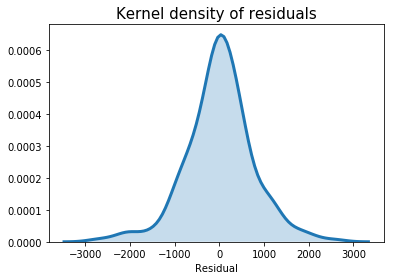

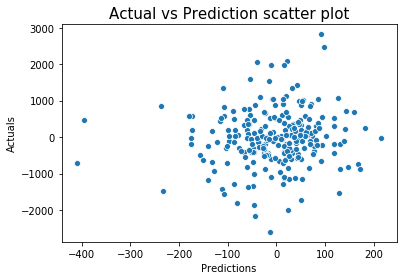

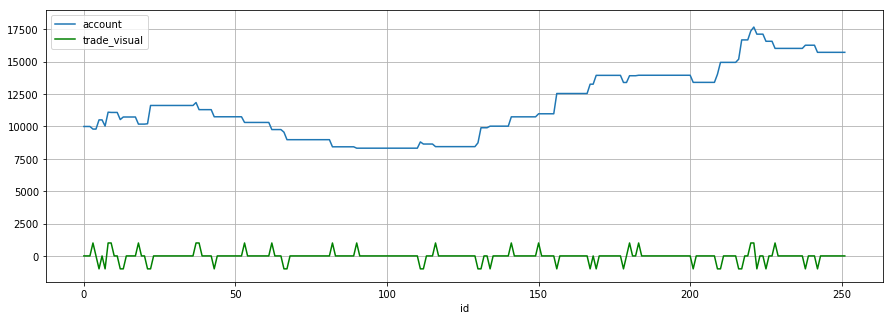

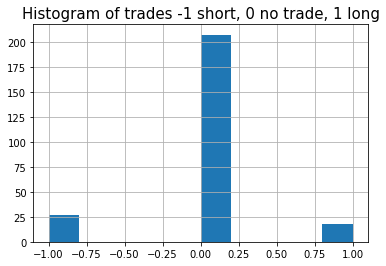

In [75]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100, name='gold_lgb')

In [76]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[330]	valid_0's l2: 175839
[331]	valid_0's l2: 175838
[332]	valid_0's l2: 175837
[333]	valid_0's l2: 175836
[334]	valid_0's l2: 175835
[335]	valid_0's l2: 175840
[336]	valid_0's l2: 175839
[337]	valid_0's l2: 175836
[338]	valid_0's l2: 175834
[339]	valid_0's l2: 175834
[340]	valid_0's l2: 175833
[341]	valid_0's l2: 175831
[342]	valid_0's l2: 175825
[343]	valid_0's l2: 175821
[344]	valid_0's l2: 175821
[345]	valid_0's l2: 175829
[346]	valid_0's l2: 175833
[347]	valid_0's l2: 175833
[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[365]	valid_0's l2: 175819
[366]	valid_0's l2: 175819
[

[664]	valid_0's l2: 175900
[665]	valid_0's l2: 175899
[666]	valid_0's l2: 175899
[667]	valid_0's l2: 175898
[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[677]	valid_0's l2: 175919
[678]	valid_0's l2: 175918
[679]	valid_0's l2: 175923
[680]	valid_0's l2: 175926
[681]	valid_0's l2: 175925
[682]	valid_0's l2: 175924
[683]	valid_0's l2: 175929
[684]	valid_0's l2: 175928
[685]	valid_0's l2: 175927
[686]	valid_0's l2: 175915
[687]	valid_0's l2: 175914
[688]	valid_0's l2: 175913
[689]	valid_0's l2: 175916
[690]	valid_0's l2: 175913
[691]	valid_0's l2: 175912
[692]	valid_0's l2: 175912
[693]	valid_0's l2: 175909
[694]	valid_0's l2: 175912
[695]	valid_0's l2: 175911
[696]	valid_0's l2: 175898
[697]	valid_0's l2: 175903
[698]	valid_0's l2: 175910
[699]	valid_0's l2: 175909
[700]	valid_0's l2: 175906
[

[993]	valid_0's l2: 175868
[994]	valid_0's l2: 175878
[995]	valid_0's l2: 175877
[996]	valid_0's l2: 175885
[997]	valid_0's l2: 175889
[998]	valid_0's l2: 175888
[999]	valid_0's l2: 175879
[1000]	valid_0's l2: 175878


Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Number of trades:  36
Number of short trades:  14
Number of long trades:  22
Earnings per trade:  6.89
Earnings per short trade:  43.29
Earnings per long trade:  -16.28
Precision score:  [0.64285714 0.1712963  0.40909091]


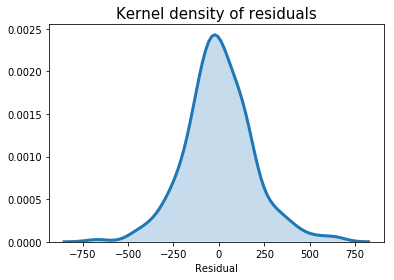

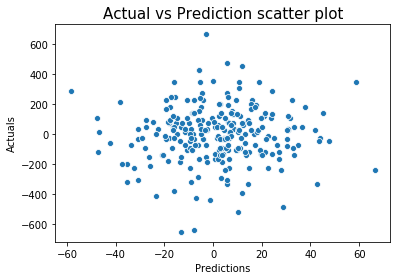

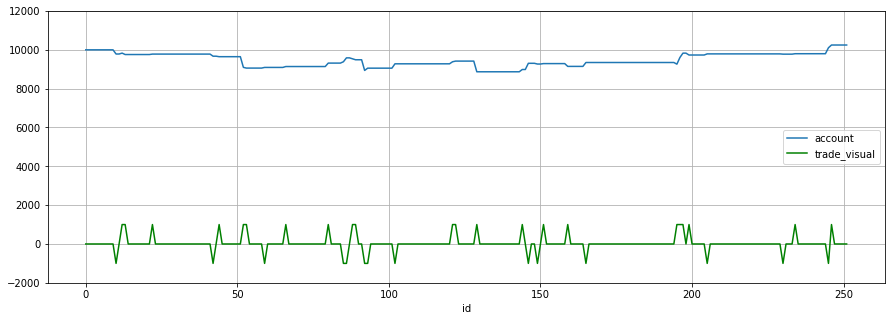

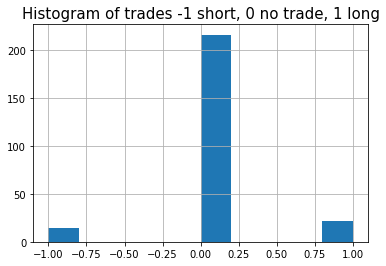

In [77]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30, name='corn_lgb')

In [78]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[349]	valid_0's l2: 161421
[350]	valid_0's l2: 161422
[351]	valid_0's l2: 161421
[352]	valid_0's l2: 161426
[353]	valid_0's l2: 161418
[354]	valid_0's l2: 161419
[355]	valid_0's l2: 161420
[356]	valid_0's l2: 161416
[357]	valid_0's l2: 161417
[358]	valid_0's l2: 161421
[359]	valid_0's l2: 161421
[360]	valid_0's l2: 161424
[361]	valid_0's l2: 161416
[362]	valid_0's l2: 161420
[363]	valid_0's l2: 161421
[364]	valid_0's l2: 161422
[365]	valid_0's l2: 161413
[366]	valid_0's l2: 161414
[367]	valid_0's l2: 161415
[368]	valid_0's l2: 161412
[369]	valid_0's l2: 161414
[370]	valid_0's l2: 161421
[371]	valid_0's l2: 161422
[372]	valid_0's l2: 161427
[373]	valid_0's l2: 161418
[374]	valid_0's l2: 161411
[375]	valid_0's l2: 161417
[

[666]	valid_0's l2: 161778
[667]	valid_0's l2: 161778
[668]	valid_0's l2: 161777
[669]	valid_0's l2: 161770
[670]	valid_0's l2: 161776
[671]	valid_0's l2: 161775
[672]	valid_0's l2: 161773
[673]	valid_0's l2: 161773
[674]	valid_0's l2: 161782
[675]	valid_0's l2: 161788
[676]	valid_0's l2: 161799
[677]	valid_0's l2: 161798
[678]	valid_0's l2: 161797
[679]	valid_0's l2: 161795
[680]	valid_0's l2: 161805
[681]	valid_0's l2: 161804
[682]	valid_0's l2: 161803
[683]	valid_0's l2: 161797
[684]	valid_0's l2: 161809
[685]	valid_0's l2: 161807
[686]	valid_0's l2: 161815
[687]	valid_0's l2: 161815
[688]	valid_0's l2: 161814
[689]	valid_0's l2: 161814
[690]	valid_0's l2: 161826
[691]	valid_0's l2: 161825
[692]	valid_0's l2: 161823
[693]	valid_0's l2: 161830
[694]	valid_0's l2: 161828
[695]	valid_0's l2: 161828
[696]	valid_0's l2: 161836
[697]	valid_0's l2: 161834
[698]	valid_0's l2: 161840
[699]	valid_0's l2: 161839
[700]	valid_0's l2: 161849
[701]	valid_0's l2: 161849
[702]	valid_0's l2: 161859
[

[979]	valid_0's l2: 162190
[980]	valid_0's l2: 162198
[981]	valid_0's l2: 162197
[982]	valid_0's l2: 162195
[983]	valid_0's l2: 162191
[984]	valid_0's l2: 162189
[985]	valid_0's l2: 162188
[986]	valid_0's l2: 162188
[987]	valid_0's l2: 162186
[988]	valid_0's l2: 162196
[989]	valid_0's l2: 162195
[990]	valid_0's l2: 162195
[991]	valid_0's l2: 162192
[992]	valid_0's l2: 162200
[993]	valid_0's l2: 162199
[994]	valid_0's l2: 162210
[995]	valid_0's l2: 162209
[996]	valid_0's l2: 162211
[997]	valid_0's l2: 162211
[998]	valid_0's l2: 162210
[999]	valid_0's l2: 162212
[1000]	valid_0's l2: 162212


Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Number of trades:  45
Number of short trades:  30
Number of long trades:  15
Earnings per trade:  75.78
Earnings per short trade:  158.71
Earnings per long trade:  -90.07
Precision score:  [0.46666667 0.0821256  0.26666667]


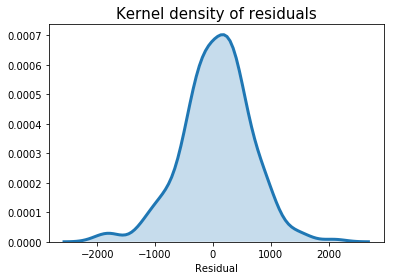

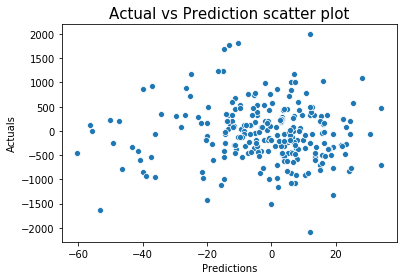

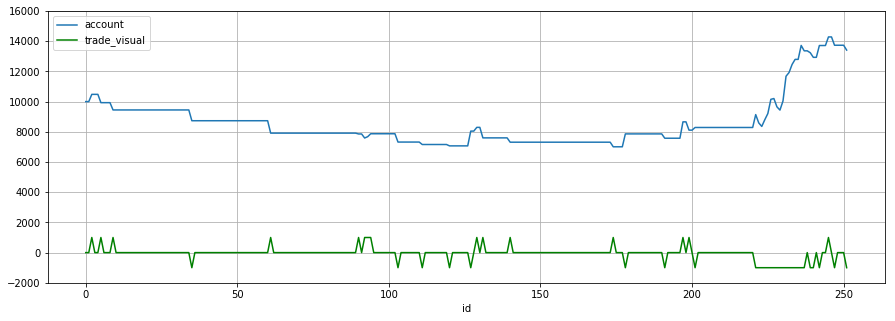

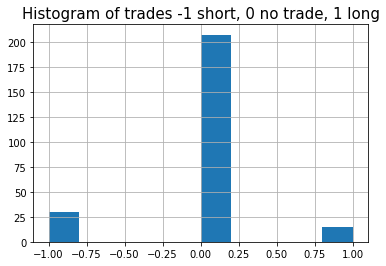

In [79]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20, name='coffee_lgb')

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee    | -100    | -90.6              | 111              |

In [80]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [81]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [82]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 200
model = define_model(input_shape, num_classes)

Using TensorFlow backend.


In [83]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [84]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1927 samples, validate on 484 samples
Epoch 1/200
1927/1927 [==============================] - 1s 706us/step - loss: 72086769212.3134 - acc: 0.3197 - val_loss: 69614595892.8926 - val_acc: 0.3099

Epoch 00001: val_loss improved from inf to 69614595892.89256, saving model to saved_models/weights.gold.hdf5
Epoch 2/200
1927/1927 [==============================] - 0s 114us/step - loss: 66084311178.1629 - acc: 0.3332 - val_loss: 63839729003.9008 - val_acc: 0.3120

Epoch 00002: val_loss improved from 69614595892.89256 to 63839729003.90083, saving model to saved_models/weights.gold.hdf5
Epoch 3/200
1927/1927 [==============================] - 0s 160us/step - loss: 60478749397.8869 - acc: 0.3311 - val_loss: 58369382044.5620 - val_acc: 0.3079

Epoch 00003: val_loss improved from 63839729003.90083 to 58369382044.56198, saving model to saved_models/weights.gold.hdf5
Epoch 4/200
1927/1927 [==============================] - 0s 114us/step - loss: 55300132016.9549 - acc: 0.3259 - val_loss: 53

1927/1927 [==============================] - 0s 100us/step - loss: 2295493202.7317 - acc: 0.2953 - val_loss: 2037681333.9504 - val_acc: 0.3079

Epoch 00030: val_loss improved from 2506569990.34711 to 2037681333.95041, saving model to saved_models/weights.gold.hdf5
Epoch 31/200
1927/1927 [==============================] - 0s 112us/step - loss: 1852169095.2071 - acc: 0.3383 - val_loss: 1622652741.2893 - val_acc: 0.3120

Epoch 00031: val_loss improved from 2037681333.95041 to 1622652741.28926, saving model to saved_models/weights.gold.hdf5
Epoch 32/200
1927/1927 [==============================] - 0s 105us/step - loss: 1461485540.0353 - acc: 0.2896 - val_loss: 1263073310.6777 - val_acc: 0.3120

Epoch 00032: val_loss improved from 1622652741.28926 to 1263073310.67769, saving model to saved_models/weights.gold.hdf5
Epoch 33/200
1927/1927 [==============================] - 0s 105us/step - loss: 1125080401.9844 - acc: 0.3228 - val_loss: 956149471.8678 - val_acc: 0.3182

Epoch 00033: val_loss i


Epoch 00064: val_loss did not improve from 166695.37209
Epoch 65/200
1927/1927 [==============================] - 0s 103us/step - loss: 181246.8368 - acc: 0.3233 - val_loss: 193391.6076 - val_acc: 0.3595

Epoch 00065: val_loss did not improve from 166695.37209
Epoch 66/200
1927/1927 [==============================] - 0s 99us/step - loss: 183695.1434 - acc: 0.3389 - val_loss: 208455.1077 - val_acc: 0.3223

Epoch 00066: val_loss did not improve from 166695.37209
Epoch 67/200
1927/1927 [==============================] - 0s 98us/step - loss: 182888.8629 - acc: 0.3191 - val_loss: 200721.7299 - val_acc: 0.3740

Epoch 00067: val_loss did not improve from 166695.37209
Epoch 68/200
1927/1927 [==============================] - 0s 96us/step - loss: 180421.8476 - acc: 0.3207 - val_loss: 187658.8157 - val_acc: 0.3223

Epoch 00068: val_loss did not improve from 166695.37209
Epoch 69/200
1927/1927 [==============================] - 0s 101us/step - loss: 182827.4542 - acc: 0.3389 - val_loss: 170986.5

1927/1927 [==============================] - 0s 102us/step - loss: 182754.4980 - acc: 0.3373 - val_loss: 168578.6686 - val_acc: 0.3512

Epoch 00104: val_loss did not improve from 162836.54108
Epoch 105/200
1927/1927 [==============================] - 0s 102us/step - loss: 181828.4444 - acc: 0.3446 - val_loss: 174382.8984 - val_acc: 0.3574

Epoch 00105: val_loss did not improve from 162836.54108
Epoch 106/200
1927/1927 [==============================] - 0s 117us/step - loss: 181772.4115 - acc: 0.3181 - val_loss: 212787.7888 - val_acc: 0.3471

Epoch 00106: val_loss did not improve from 162836.54108
Epoch 107/200
1927/1927 [==============================] - 0s 110us/step - loss: 178869.3267 - acc: 0.3295 - val_loss: 209251.7477 - val_acc: 0.3533

Epoch 00107: val_loss did not improve from 162836.54108
Epoch 108/200
1927/1927 [==============================] - 0s 106us/step - loss: 187866.2248 - acc: 0.3435 - val_loss: 188030.9665 - val_acc: 0.3430

Epoch 00108: val_loss did not improve fr


Epoch 00143: val_loss did not improve from 159224.68169
Epoch 144/200
1927/1927 [==============================] - 0s 103us/step - loss: 180285.6843 - acc: 0.3124 - val_loss: 188740.4446 - val_acc: 0.3636

Epoch 00144: val_loss did not improve from 159224.68169
Epoch 145/200
1927/1927 [==============================] - 0s 107us/step - loss: 183453.7396 - acc: 0.3430 - val_loss: 211018.1422 - val_acc: 0.3285

Epoch 00145: val_loss did not improve from 159224.68169
Epoch 146/200
1927/1927 [==============================] - 0s 101us/step - loss: 183601.6143 - acc: 0.3487 - val_loss: 203961.3413 - val_acc: 0.3616

Epoch 00146: val_loss did not improve from 159224.68169
Epoch 147/200
1927/1927 [==============================] - 0s 101us/step - loss: 184161.5965 - acc: 0.3207 - val_loss: 164305.7671 - val_acc: 0.3864

Epoch 00147: val_loss did not improve from 159224.68169
Epoch 148/200
1927/1927 [==============================] - 0s 103us/step - loss: 179622.2070 - acc: 0.3347 - val_loss: 

1927/1927 [==============================] - 0s 104us/step - loss: 181083.5561 - acc: 0.3259 - val_loss: 192639.5312 - val_acc: 0.3595

Epoch 00183: val_loss did not improve from 154191.77454
Epoch 184/200
1927/1927 [==============================] - 0s 102us/step - loss: 186874.5045 - acc: 0.3415 - val_loss: 172412.2174 - val_acc: 0.3533

Epoch 00184: val_loss did not improve from 154191.77454
Epoch 185/200
1927/1927 [==============================] - 0s 114us/step - loss: 181258.7380 - acc: 0.3467 - val_loss: 183916.4173 - val_acc: 0.3264

Epoch 00185: val_loss did not improve from 154191.77454
Epoch 186/200
1927/1927 [==============================] - 0s 101us/step - loss: 179337.9376 - acc: 0.3233 - val_loss: 178697.6565 - val_acc: 0.3533

Epoch 00186: val_loss did not improve from 154191.77454
Epoch 187/200
1927/1927 [==============================] - 0s 113us/step - loss: 183873.6752 - acc: 0.3134 - val_loss: 190342.9421 - val_acc: 0.3740

Epoch 00187: val_loss did not improve fr

In [85]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  150.59 %
Number of trades:  173
Number of short trades:  82
Number of long trades:  91
Earnings per trade:  87.05
Earnings per short trade:  83.60
Earnings per long trade:  90.15
Precision score:  [0.17073171 0.5443038  0.1978022 ]


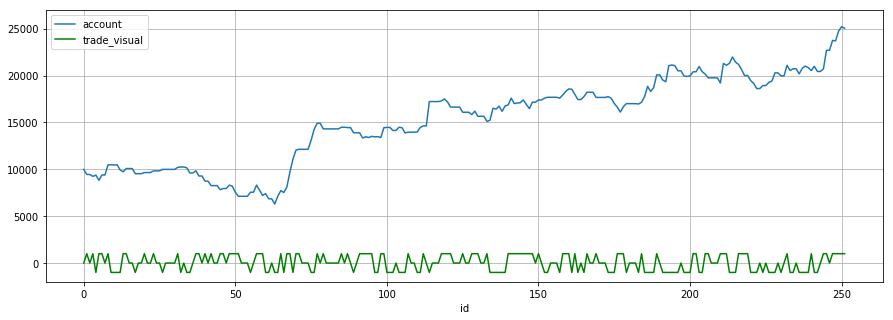

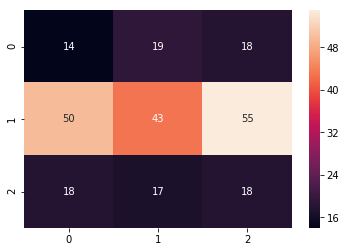

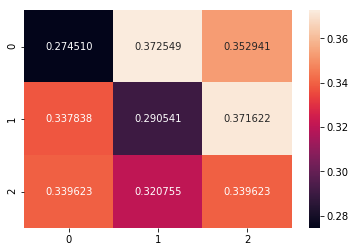

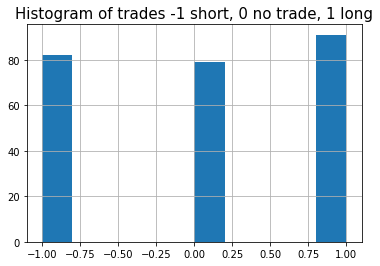

In [86]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_nn_cls', regression=False)

In [87]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1928 samples, validate on 483 samples
Epoch 1/200
1928/1928 [==============================] - 1s 546us/step - loss: 65475493412.1162 - acc: 0.3371 - val_loss: 62079432835.4451 - val_acc: 0.2961

Epoch 00001: val_loss improved from inf to 62079432835.44514, saving model to saved_models/weights.corn.hdf5
Epoch 2/200
1928/1928 [==============================] - 0s 137us/step - loss: 59464736054.1743 - acc: 0.3195 - val_loss: 56414850563.1801 - val_acc: 0.3023

Epoch 00002: val_loss improved from 62079432835.44514 to 56414850563.18012, saving model to saved_models/weights.corn.hdf5
Epoch 3/200
1928/1928 [==============================] - 0s 139us/step - loss: 54000388240.4647 - acc: 0.3148 - val_loss: 51208784876.9193 - val_acc: 0.2961

Epoch 00003: val_loss improved from 56414850563.18012 to 51208784876.91926, saving model to saved_models/weights.corn.hdf5
Epoch 4/200
1928/1928 [==============================] - 0s 138us/step - loss: 48886347274.6224 - acc: 0.3294 - val_loss: 46

1928/1928 [==============================] - 0s 178us/step - loss: 1993158313.9585 - acc: 0.3470 - val_loss: 1776137237.2008 - val_acc: 0.3002

Epoch 00030: val_loss improved from 2151208256.66253 to 1776137237.20083, saving model to saved_models/weights.corn.hdf5
Epoch 31/200
1928/1928 [==============================] - 0s 113us/step - loss: 1634847364.7801 - acc: 0.3268 - val_loss: 1442807054.9731 - val_acc: 0.2940

Epoch 00031: val_loss improved from 1776137237.20083 to 1442807054.97308, saving model to saved_models/weights.corn.hdf5
Epoch 32/200
1928/1928 [==============================] - 0s 112us/step - loss: 1317263916.8797 - acc: 0.3351 - val_loss: 1150128277.3665 - val_acc: 0.2919

Epoch 00032: val_loss improved from 1442807054.97308 to 1150128277.36646, saving model to saved_models/weights.corn.hdf5
Epoch 33/200
1928/1928 [==============================] - 0s 106us/step - loss: 1040069635.0539 - acc: 0.3216 - val_loss: 894251299.9420 - val_acc: 0.2940

Epoch 00033: val_loss i

1928/1928 [==============================] - 0s 118us/step - loss: 155839.0249 - acc: 0.3579 - val_loss: 162979.2200 - val_acc: 0.3582

Epoch 00064: val_loss did not improve from 132867.37680
Epoch 65/200
1928/1928 [==============================] - 0s 114us/step - loss: 154647.5671 - acc: 0.3371 - val_loss: 144061.4248 - val_acc: 0.3043

Epoch 00065: val_loss did not improve from 132867.37680
Epoch 66/200
1928/1928 [==============================] - 0s 111us/step - loss: 160506.3883 - acc: 0.3392 - val_loss: 125047.6959 - val_acc: 0.3168

Epoch 00066: val_loss improved from 132867.37680 to 125047.69591, saving model to saved_models/weights.corn.hdf5
Epoch 67/200
1928/1928 [==============================] - 0s 120us/step - loss: 154761.8637 - acc: 0.3262 - val_loss: 157130.6683 - val_acc: 0.3416

Epoch 00067: val_loss did not improve from 125047.69591
Epoch 68/200
1928/1928 [==============================] - 0s 111us/step - loss: 156854.9124 - acc: 0.3096 - val_loss: 146175.9926 - val_

1928/1928 [==============================] - 0s 112us/step - loss: 157247.2055 - acc: 0.3558 - val_loss: 154629.2530 - val_acc: 0.3209

Epoch 00104: val_loss did not improve from 125047.69591
Epoch 105/200
1928/1928 [==============================] - 0s 113us/step - loss: 157372.4658 - acc: 0.3392 - val_loss: 170581.4531 - val_acc: 0.3458

Epoch 00105: val_loss did not improve from 125047.69591
Epoch 106/200
1928/1928 [==============================] - 0s 115us/step - loss: 156264.0832 - acc: 0.3262 - val_loss: 153073.6995 - val_acc: 0.3561

Epoch 00106: val_loss did not improve from 125047.69591
Epoch 107/200
1928/1928 [==============================] - 0s 104us/step - loss: 154807.3588 - acc: 0.3309 - val_loss: 162984.6574 - val_acc: 0.3168

Epoch 00107: val_loss did not improve from 125047.69591
Epoch 108/200
1928/1928 [==============================] - 0s 103us/step - loss: 157181.9048 - acc: 0.3361 - val_loss: 134807.6611 - val_acc: 0.2940

Epoch 00108: val_loss did not improve fr

1928/1928 [==============================] - 0s 108us/step - loss: 156020.7394 - acc: 0.3387 - val_loss: 157610.9624 - val_acc: 0.2981

Epoch 00144: val_loss did not improve from 125047.69591
Epoch 145/200
1928/1928 [==============================] - 0s 108us/step - loss: 154392.6759 - acc: 0.3304 - val_loss: 156588.0373 - val_acc: 0.3582

Epoch 00145: val_loss did not improve from 125047.69591
Epoch 146/200
1928/1928 [==============================] - 0s 102us/step - loss: 157361.5177 - acc: 0.3356 - val_loss: 149749.4615 - val_acc: 0.3644

Epoch 00146: val_loss did not improve from 125047.69591
Epoch 147/200
1928/1928 [==============================] - 0s 107us/step - loss: 158788.3172 - acc: 0.3257 - val_loss: 145120.8719 - val_acc: 0.3251

Epoch 00147: val_loss did not improve from 125047.69591
Epoch 148/200
1928/1928 [==============================] - 0s 104us/step - loss: 152879.1340 - acc: 0.3143 - val_loss: 155478.8342 - val_acc: 0.3002

Epoch 00148: val_loss did not improve fr


Epoch 00183: val_loss did not improve from 120061.57915
Epoch 184/200
1928/1928 [==============================] - 0s 104us/step - loss: 157791.7423 - acc: 0.3377 - val_loss: 140666.9306 - val_acc: 0.3602

Epoch 00184: val_loss did not improve from 120061.57915
Epoch 185/200
1928/1928 [==============================] - 0s 110us/step - loss: 152804.7043 - acc: 0.3465 - val_loss: 190494.2973 - val_acc: 0.3665

Epoch 00185: val_loss did not improve from 120061.57915
Epoch 186/200
1928/1928 [==============================] - 0s 108us/step - loss: 157077.1547 - acc: 0.3413 - val_loss: 167415.5054 - val_acc: 0.3478

Epoch 00186: val_loss did not improve from 120061.57915
Epoch 187/200
1928/1928 [==============================] - 0s 104us/step - loss: 158928.9745 - acc: 0.3449 - val_loss: 141507.5017 - val_acc: 0.3333

Epoch 00187: val_loss did not improve from 120061.57915
Epoch 188/200
1928/1928 [==============================] - 0s 106us/step - loss: 155440.2966 - acc: 0.3361 - val_loss: 

Returns  -43.32 %
Number of trades:  190
Number of short trades:  154
Number of long trades:  36
Earnings per trade:  -22.80
Earnings per short trade:  -18.85
Earnings per long trade:  -39.68
Precision score:  [0.17532468 0.64516129 0.16666667]


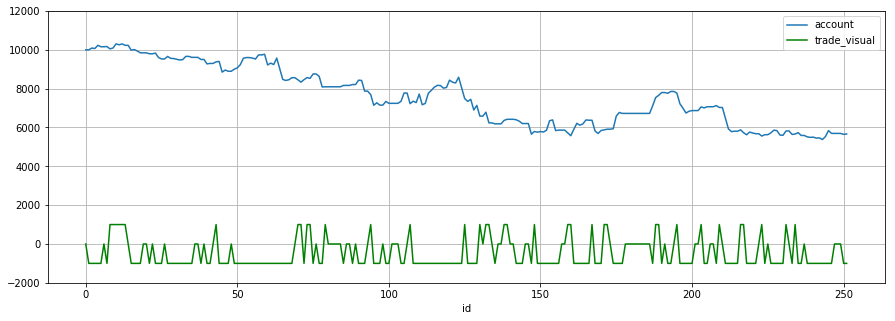

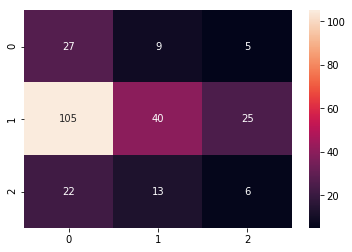

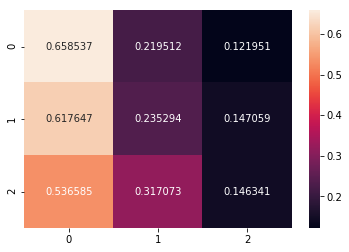

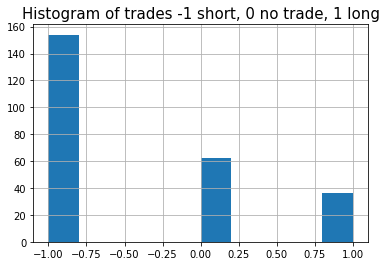

In [88]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_nn_cls')

In [89]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/200
1923/1923 [==============================] - 1s 667us/step - loss: 4565846940.8216 - acc: 0.3401 - val_loss: 4390317617.2308 - val_acc: 0.3825

Epoch 00001: val_loss improved from inf to 4390317617.23077, saving model to saved_models/weights.coffee.hdf5
Epoch 2/200
1923/1923 [==============================] - 0s 114us/step - loss: 4423879958.5647 - acc: 0.3562 - val_loss: 4238754326.8857 - val_acc: 0.3805

Epoch 00002: val_loss improved from 4390317617.23077 to 4238754326.88565, saving model to saved_models/weights.coffee.hdf5
Epoch 3/200
1923/1923 [==============================] - 0s 123us/step - loss: 4266143908.4763 - acc: 0.3469 - val_loss: 4092837255.1850 - val_acc: 0.3825

Epoch 00003: val_loss improved from 4238754326.88565 to 4092837255.18503, saving model to saved_models/weights.coffee.hdf5
Epoch 4/200
1923/1923 [==============================] - 0s 131us/step - loss: 4126532608.3578 - acc: 0.3505 - val_loss: 39508080

1923/1923 [==============================] - 0s 108us/step - loss: 1467013709.8606 - acc: 0.3583 - val_loss: 1381792461.7048 - val_acc: 0.3617

Epoch 00030: val_loss improved from 1452010151.98337 to 1381792461.70478, saving model to saved_models/weights.coffee.hdf5
Epoch 31/200
1923/1923 [==============================] - 0s 107us/step - loss: 1397141818.5970 - acc: 0.3604 - val_loss: 1315096144.6985 - val_acc: 0.3576

Epoch 00031: val_loss improved from 1381792461.70478 to 1315096144.69854, saving model to saved_models/weights.coffee.hdf5
Epoch 32/200
1923/1923 [==============================] - 0s 111us/step - loss: 1325334876.9880 - acc: 0.3573 - val_loss: 1249744790.0873 - val_acc: 0.3659

Epoch 00032: val_loss improved from 1315096144.69854 to 1249744790.08732, saving model to saved_models/weights.coffee.hdf5
Epoch 33/200
1923/1923 [==============================] - 0s 108us/step - loss: 1260089775.2595 - acc: 0.3599 - val_loss: 1186590734.9023 - val_acc: 0.3617

Epoch 00033: val

1923/1923 [==============================] - 0s 111us/step - loss: 138731389.6817 - acc: 0.3458 - val_loss: 120851855.8378 - val_acc: 0.3617

Epoch 00060: val_loss improved from 139463174.65696 to 120851855.83784, saving model to saved_models/weights.coffee.hdf5
Epoch 61/200
1923/1923 [==============================] - 0s 108us/step - loss: 119705480.0874 - acc: 0.3573 - val_loss: 103363274.3077 - val_acc: 0.3742

Epoch 00061: val_loss improved from 120851855.83784 to 103363274.30769, saving model to saved_models/weights.coffee.hdf5
Epoch 62/200
1923/1923 [==============================] - 0s 118us/step - loss: 102548456.9561 - acc: 0.3578 - val_loss: 87626681.5593 - val_acc: 0.3659

Epoch 00062: val_loss improved from 103363274.30769 to 87626681.55925, saving model to saved_models/weights.coffee.hdf5
Epoch 63/200
1923/1923 [==============================] - 0s 114us/step - loss: 86563299.2448 - acc: 0.3573 - val_loss: 73053479.4158 - val_acc: 0.3680

Epoch 00063: val_loss improved fro

1923/1923 [==============================] - 0s 109us/step - loss: 51801.8658 - acc: 0.3557 - val_loss: 53873.9127 - val_acc: 0.3472

Epoch 00093: val_loss did not improve from 50709.08168
Epoch 94/200
1923/1923 [==============================] - 0s 111us/step - loss: 51638.1783 - acc: 0.3344 - val_loss: 55451.9236 - val_acc: 0.3264

Epoch 00094: val_loss did not improve from 50709.08168
Epoch 95/200
1923/1923 [==============================] - 0s 124us/step - loss: 53275.8427 - acc: 0.3307 - val_loss: 56594.3930 - val_acc: 0.3243

Epoch 00095: val_loss did not improve from 50709.08168
Epoch 96/200
1923/1923 [==============================] - 0s 131us/step - loss: 51802.8900 - acc: 0.3344 - val_loss: 49614.3310 - val_acc: 0.3410

Epoch 00096: val_loss improved from 50709.08168 to 49614.33095, saving model to saved_models/weights.coffee.hdf5
Epoch 97/200
1923/1923 [==============================] - 0s 111us/step - loss: 52730.9712 - acc: 0.3307 - val_loss: 51463.9525 - val_acc: 0.3056




Epoch 00132: val_loss did not improve from 46688.52160
Epoch 133/200
1923/1923 [==============================] - 0s 114us/step - loss: 52082.0042 - acc: 0.3474 - val_loss: 49061.9489 - val_acc: 0.3077

Epoch 00133: val_loss did not improve from 46688.52160
Epoch 134/200
1923/1923 [==============================] - 0s 136us/step - loss: 50969.1711 - acc: 0.3427 - val_loss: 56373.1151 - val_acc: 0.2931

Epoch 00134: val_loss did not improve from 46688.52160
Epoch 135/200
1923/1923 [==============================] - 0s 102us/step - loss: 50423.6119 - acc: 0.3323 - val_loss: 59458.1959 - val_acc: 0.3077

Epoch 00135: val_loss did not improve from 46688.52160
Epoch 136/200
1923/1923 [==============================] - 0s 109us/step - loss: 54356.6213 - acc: 0.3380 - val_loss: 54251.0871 - val_acc: 0.3264

Epoch 00136: val_loss did not improve from 46688.52160
Epoch 137/200
1923/1923 [==============================] - 0s 116us/step - loss: 49369.5892 - acc: 0.3229 - val_loss: 57527.6079 - v

1923/1923 [==============================] - 0s 108us/step - loss: 51282.5641 - acc: 0.3365 - val_loss: 52947.9033 - val_acc: 0.2973

Epoch 00173: val_loss did not improve from 46688.52160
Epoch 174/200
1923/1923 [==============================] - 0s 101us/step - loss: 53340.1599 - acc: 0.3125 - val_loss: 50174.1894 - val_acc: 0.2869

Epoch 00174: val_loss did not improve from 46688.52160
Epoch 175/200
1923/1923 [==============================] - 0s 111us/step - loss: 49121.5932 - acc: 0.3354 - val_loss: 58131.8214 - val_acc: 0.2973

Epoch 00175: val_loss did not improve from 46688.52160
Epoch 176/200
1923/1923 [==============================] - 0s 105us/step - loss: 51757.2826 - acc: 0.3162 - val_loss: 56288.2428 - val_acc: 0.2723

Epoch 00176: val_loss did not improve from 46688.52160
Epoch 177/200
1923/1923 [==============================] - 0s 104us/step - loss: 52741.2299 - acc: 0.3120 - val_loss: 54370.6409 - val_acc: 0.3056

Epoch 00177: val_loss did not improve from 46688.52160

Returns  -102.01 %
Number of trades:  22
Number of short trades:  3
Number of long trades:  19
Earnings per trade:  -463.70
Earnings per short trade:  -278.10
Earnings per long trade:  -493.01
Precision score:  [0.         0.33333333 0.21052632]


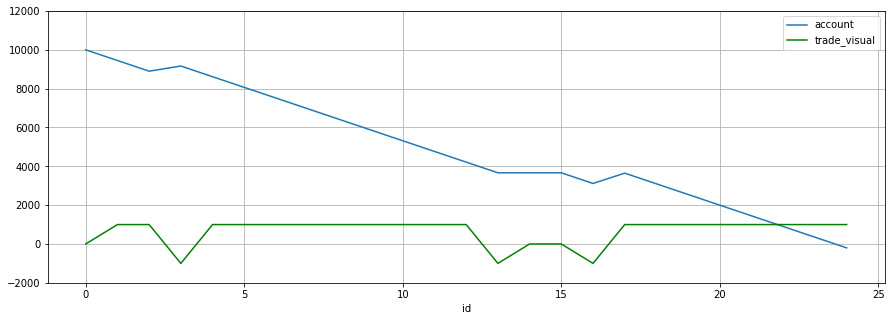

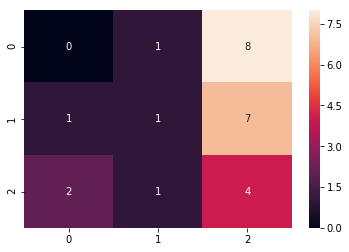

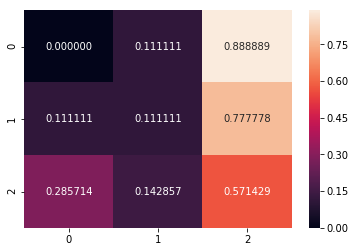

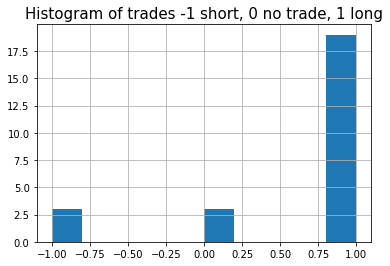

In [90]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300, name='coffee_nn_cls')

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [91]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [92]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [93]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1927 samples, validate on 484 samples
Epoch 1/1000
1927/1927 [==============================] - 3s 1ms/step - loss: 1279856.2296 - val_loss: 1215187.9243

Epoch 00001: val_loss improved from inf to 1215187.92433, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1927/1927 [==============================] - 0s 155us/step - loss: 1279836.4314 - val_loss: 1215187.8401

Epoch 00002: val_loss improved from 1215187.92433 to 1215187.84013, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/1000
1927/1927 [==============================] - ETA: 0s - loss: 1288607.699 - 0s 161us/step - loss: 1279822.9709 - val_loss: 1215188.0723

Epoch 00003: val_loss did not improve from 1215187.84013
Epoch 4/1000
1927/1927 [==============================] - 0s 156us/step - loss: 1279813.3826 - val_loss: 1215187.4747

Epoch 00004: val_loss improved from 1215187.84013 to 1215187.47469, saving model to saved_models/weights.gold_reg.hdf5
Epoch 5/1000
1927/1927 [=====================

1927/1927 [==============================] - 0s 141us/step - loss: 1279512.8494 - val_loss: 1215169.3468

Epoch 00043: val_loss improved from 1215173.86054 to 1215169.34685, saving model to saved_models/weights.gold_reg.hdf5
Epoch 44/1000
1927/1927 [==============================] - 0s 134us/step - loss: 1279518.5690 - val_loss: 1215163.8598

Epoch 00044: val_loss improved from 1215169.34685 to 1215163.85976, saving model to saved_models/weights.gold_reg.hdf5
Epoch 45/1000
1927/1927 [==============================] - 0s 144us/step - loss: 1279448.9435 - val_loss: 1215157.9863

Epoch 00045: val_loss improved from 1215163.85976 to 1215157.98631, saving model to saved_models/weights.gold_reg.hdf5
Epoch 46/1000
1927/1927 [==============================] - 0s 160us/step - loss: 1279451.0209 - val_loss: 1215152.1002

Epoch 00046: val_loss improved from 1215157.98631 to 1215152.10021, saving model to saved_models/weights.gold_reg.hdf5
Epoch 47/1000
1927/1927 [==============================] -


Epoch 00078: val_loss did not improve from 1214829.99199
Epoch 79/1000
1927/1927 [==============================] - 0s 143us/step - loss: 1275133.5524 - val_loss: 1214834.0253

Epoch 00079: val_loss did not improve from 1214829.99199
Epoch 80/1000
1927/1927 [==============================] - 0s 137us/step - loss: 1275148.3712 - val_loss: 1214795.5145

Epoch 00080: val_loss improved from 1214829.99199 to 1214795.51446, saving model to saved_models/weights.gold_reg.hdf5
Epoch 81/1000
1927/1927 [==============================] - 0s 145us/step - loss: 1274542.3237 - val_loss: 1214768.2740

Epoch 00081: val_loss improved from 1214795.51446 to 1214768.27402, saving model to saved_models/weights.gold_reg.hdf5
Epoch 82/1000
1927/1927 [==============================] - 0s 142us/step - loss: 1274209.2241 - val_loss: 1214729.7472

Epoch 00082: val_loss improved from 1214768.27402 to 1214729.74716, saving model to saved_models/weights.gold_reg.hdf5
Epoch 83/1000
1927/1927 [=======================

1927/1927 [==============================] - 0s 171us/step - loss: 1266258.3053 - val_loss: 1214316.6635

Epoch 00117: val_loss did not improve from 1214311.51291
Epoch 118/1000
1927/1927 [==============================] - 0s 151us/step - loss: 1265859.0255 - val_loss: 1214289.3871

Epoch 00118: val_loss improved from 1214311.51291 to 1214289.38714, saving model to saved_models/weights.gold_reg.hdf5
Epoch 119/1000
1927/1927 [==============================] - 0s 157us/step - loss: 1265539.3664 - val_loss: 1214254.4974

Epoch 00119: val_loss improved from 1214289.38714 to 1214254.49742, saving model to saved_models/weights.gold_reg.hdf5
Epoch 120/1000
1927/1927 [==============================] - 0s 158us/step - loss: 1265767.1969 - val_loss: 1214243.4739

Epoch 00120: val_loss improved from 1214254.49742 to 1214243.47392, saving model to saved_models/weights.gold_reg.hdf5
Epoch 121/1000
1927/1927 [==============================] - 0s 165us/step - loss: 1264900.9292 - val_loss: 1214235.65


Epoch 00157: val_loss improved from 1213828.77660 to 1213792.46126, saving model to saved_models/weights.gold_reg.hdf5
Epoch 158/1000
1927/1927 [==============================] - 0s 147us/step - loss: 1253025.2297 - val_loss: 1213821.9597

Epoch 00158: val_loss did not improve from 1213792.46126
Epoch 159/1000
1927/1927 [==============================] - 0s 161us/step - loss: 1253412.5198 - val_loss: 1213749.9411

Epoch 00159: val_loss improved from 1213792.46126 to 1213749.94112, saving model to saved_models/weights.gold_reg.hdf5
Epoch 160/1000
1927/1927 [==============================] - 0s 156us/step - loss: 1252413.1449 - val_loss: 1213709.2319

Epoch 00160: val_loss improved from 1213749.94112 to 1213709.23192, saving model to saved_models/weights.gold_reg.hdf5
Epoch 161/1000
1927/1927 [==============================] - 0s 152us/step - loss: 1251697.3233 - val_loss: 1213780.1278

Epoch 00161: val_loss did not improve from 1213709.23192
Epoch 162/1000
1927/1927 [==================

1927/1927 [==============================] - 0s 145us/step - loss: 1237949.6748 - val_loss: 1213290.3024

Epoch 00200: val_loss did not improve from 1213268.05320
Epoch 201/1000
1927/1927 [==============================] - 0s 153us/step - loss: 1237548.7524 - val_loss: 1213366.6018

Epoch 00201: val_loss did not improve from 1213268.05320
Epoch 202/1000
1927/1927 [==============================] - 0s 159us/step - loss: 1237104.3326 - val_loss: 1213308.0483

Epoch 00202: val_loss did not improve from 1213268.05320
Epoch 203/1000
1927/1927 [==============================] - 0s 146us/step - loss: 1237845.8500 - val_loss: 1213173.5863

Epoch 00203: val_loss improved from 1213268.05320 to 1213173.58626, saving model to saved_models/weights.gold_reg.hdf5
Epoch 204/1000
1927/1927 [==============================] - 0s 151us/step - loss: 1236141.2874 - val_loss: 1213091.7064

Epoch 00204: val_loss improved from 1213173.58626 to 1213091.70635, saving model to saved_models/weights.gold_reg.hdf5
E


Epoch 00242: val_loss did not improve from 1212518.11880
Epoch 243/1000
1927/1927 [==============================] - 0s 141us/step - loss: 1220829.2023 - val_loss: 1212396.6247

Epoch 00243: val_loss improved from 1212518.11880 to 1212396.62474, saving model to saved_models/weights.gold_reg.hdf5
Epoch 244/1000
1927/1927 [==============================] - 0s 141us/step - loss: 1218994.5430 - val_loss: 1212353.1508

Epoch 00244: val_loss improved from 1212396.62474 to 1212353.15083, saving model to saved_models/weights.gold_reg.hdf5
Epoch 245/1000
1927/1927 [==============================] - 0s 153us/step - loss: 1218213.6540 - val_loss: 1212271.2218

Epoch 00245: val_loss improved from 1212353.15083 to 1212271.22185, saving model to saved_models/weights.gold_reg.hdf5
Epoch 246/1000
1927/1927 [==============================] - 0s 147us/step - loss: 1218377.2386 - val_loss: 1212275.1898

Epoch 00246: val_loss did not improve from 1212271.22185
Epoch 247/1000
1927/1927 [==================

1927/1927 [==============================] - 0s 151us/step - loss: 1200337.3786 - val_loss: 1211607.1599

Epoch 00283: val_loss did not improve from 1211496.14205
Epoch 284/1000
1927/1927 [==============================] - 0s 149us/step - loss: 1201878.7749 - val_loss: 1211643.5966

Epoch 00284: val_loss did not improve from 1211496.14205
Epoch 285/1000
1927/1927 [==============================] - 0s 179us/step - loss: 1199595.0029 - val_loss: 1211709.5548

Epoch 00285: val_loss did not improve from 1211496.14205
Epoch 286/1000
1927/1927 [==============================] - 0s 208us/step - loss: 1199928.8874 - val_loss: 1211783.9558

Epoch 00286: val_loss did not improve from 1211496.14205
Epoch 287/1000
1927/1927 [==============================] - 0s 243us/step - loss: 1198792.4340 - val_loss: 1211823.9491

Epoch 00287: val_loss did not improve from 1211496.14205
Epoch 288/1000
1927/1927 [==============================] - 0s 151us/step - loss: 1197417.6461 - val_loss: 1211638.0238

Epoc

1927/1927 [==============================] - 0s 183us/step - loss: 1175715.8922 - val_loss: 1212229.6028

Epoch 00329: val_loss did not improve from 1211482.91271
Epoch 330/1000
1927/1927 [==============================] - 0s 144us/step - loss: 1176733.5911 - val_loss: 1212301.5801

Epoch 00330: val_loss did not improve from 1211482.91271
Epoch 331/1000
1927/1927 [==============================] - 0s 162us/step - loss: 1174390.9881 - val_loss: 1212037.2123

Epoch 00331: val_loss did not improve from 1211482.91271
Epoch 332/1000
1927/1927 [==============================] - 0s 156us/step - loss: 1174435.7859 - val_loss: 1212109.6686

Epoch 00332: val_loss did not improve from 1211482.91271
Epoch 333/1000
1927/1927 [==============================] - 0s 176us/step - loss: 1170988.3971 - val_loss: 1212162.8417

Epoch 00333: val_loss did not improve from 1211482.91271
Epoch 334/1000
1927/1927 [==============================] - 0s 176us/step - loss: 1171819.4631 - val_loss: 1212335.4303

Epoc

1927/1927 [==============================] - 0s 146us/step - loss: 1149820.5697 - val_loss: 1211648.9241

Epoch 00374: val_loss did not improve from 1211257.18518
Epoch 375/1000
1927/1927 [==============================] - 0s 138us/step - loss: 1148369.0535 - val_loss: 1211593.7247

Epoch 00375: val_loss did not improve from 1211257.18518
Epoch 376/1000
1927/1927 [==============================] - 0s 143us/step - loss: 1147056.7429 - val_loss: 1211576.7477

Epoch 00376: val_loss did not improve from 1211257.18518
Epoch 377/1000
1927/1927 [==============================] - 0s 137us/step - loss: 1148474.4603 - val_loss: 1211611.6841

Epoch 00377: val_loss did not improve from 1211257.18518
Epoch 378/1000
1927/1927 [==============================] - 0s 144us/step - loss: 1147337.8059 - val_loss: 1211665.1364

Epoch 00378: val_loss did not improve from 1211257.18518
Epoch 379/1000
1927/1927 [==============================] - 0s 147us/step - loss: 1145273.6665 - val_loss: 1212056.1994

Epoc

1927/1927 [==============================] - 0s 183us/step - loss: 1118792.5971 - val_loss: 1211579.1909

Epoch 00419: val_loss did not improve from 1210937.20041
Epoch 420/1000
1927/1927 [==============================] - 0s 188us/step - loss: 1117086.1758 - val_loss: 1211625.8755

Epoch 00420: val_loss did not improve from 1210937.20041
Epoch 421/1000
1927/1927 [==============================] - 0s 198us/step - loss: 1120366.2100 - val_loss: 1211517.7185

Epoch 00421: val_loss did not improve from 1210937.20041
Epoch 422/1000
1927/1927 [==============================] - 0s 228us/step - loss: 1118923.8869 - val_loss: 1211420.8487

Epoch 00422: val_loss did not improve from 1210937.20041
Epoch 423/1000
1927/1927 [==============================] - 0s 251us/step - loss: 1118420.6496 - val_loss: 1211386.0248

Epoch 00423: val_loss did not improve from 1210937.20041
Epoch 424/1000
1927/1927 [==============================] - 0s 172us/step - loss: 1115781.3496 - val_loss: 1211338.3239

Epoc

1927/1927 [==============================] - 0s 144us/step - loss: 1090524.6053 - val_loss: 1213942.2585

Epoch 00465: val_loss did not improve from 1210937.20041
Epoch 466/1000
1927/1927 [==============================] - 0s 146us/step - loss: 1094467.7304 - val_loss: 1213638.0976

Epoch 00466: val_loss did not improve from 1210937.20041
Epoch 467/1000
1927/1927 [==============================] - 0s 140us/step - loss: 1091216.5285 - val_loss: 1213515.0010

Epoch 00467: val_loss did not improve from 1210937.20041
Epoch 468/1000
1927/1927 [==============================] - 0s 153us/step - loss: 1089288.3850 - val_loss: 1213513.1676

Epoch 00468: val_loss did not improve from 1210937.20041
Epoch 469/1000
1927/1927 [==============================] - 0s 150us/step - loss: 1084846.4690 - val_loss: 1213381.2095

Epoch 00469: val_loss did not improve from 1210937.20041
Epoch 470/1000
1927/1927 [==============================] - 0s 150us/step - loss: 1088381.2223 - val_loss: 1213229.5891

Epoc

1927/1927 [==============================] - 0s 147us/step - loss: 1056935.5539 - val_loss: 1213155.2975

Epoch 00511: val_loss did not improve from 1210937.20041
Epoch 512/1000
1927/1927 [==============================] - 0s 144us/step - loss: 1057192.5697 - val_loss: 1212919.0261

Epoch 00512: val_loss did not improve from 1210937.20041
Epoch 513/1000
1927/1927 [==============================] - 0s 207us/step - loss: 1056071.6825 - val_loss: 1212894.8572

Epoch 00513: val_loss did not improve from 1210937.20041
Epoch 514/1000
1927/1927 [==============================] - 0s 205us/step - loss: 1058611.4175 - val_loss: 1213277.2115

Epoch 00514: val_loss did not improve from 1210937.20041
Epoch 515/1000
1927/1927 [==============================] - 0s 147us/step - loss: 1059851.1328 - val_loss: 1213572.6315

Epoch 00515: val_loss did not improve from 1210937.20041
Epoch 516/1000
1927/1927 [==============================] - 0s 145us/step - loss: 1058035.7199 - val_loss: 1213173.6240

Epoc

1927/1927 [==============================] - 0s 142us/step - loss: 1021245.7137 - val_loss: 1215158.5289

Epoch 00557: val_loss did not improve from 1210937.20041
Epoch 558/1000
1927/1927 [==============================] - 0s 160us/step - loss: 1018195.6684 - val_loss: 1215517.8350

Epoch 00558: val_loss did not improve from 1210937.20041
Epoch 559/1000
1927/1927 [==============================] - 0s 147us/step - loss: 1019839.4166 - val_loss: 1215205.3626

Epoch 00559: val_loss did not improve from 1210937.20041
Epoch 560/1000
1927/1927 [==============================] - 0s 153us/step - loss: 1013702.2307 - val_loss: 1215091.4347

Epoch 00560: val_loss did not improve from 1210937.20041
Epoch 561/1000
1927/1927 [==============================] - 0s 146us/step - loss: 1016469.7504 - val_loss: 1214735.2836

Epoch 00561: val_loss did not improve from 1210937.20041
Epoch 562/1000
1927/1927 [==============================] - 0s 150us/step - loss: 1014742.8993 - val_loss: 1215080.7939

Epoc

1927/1927 [==============================] - 0s 153us/step - loss: 986056.5327 - val_loss: 1217413.2337

Epoch 00603: val_loss did not improve from 1210937.20041
Epoch 604/1000
1927/1927 [==============================] - 0s 140us/step - loss: 978644.6246 - val_loss: 1217906.8918

Epoch 00604: val_loss did not improve from 1210937.20041
Epoch 605/1000
1927/1927 [==============================] - 0s 138us/step - loss: 984133.9725 - val_loss: 1217650.0504

Epoch 00605: val_loss did not improve from 1210937.20041
Epoch 606/1000
1927/1927 [==============================] - 0s 143us/step - loss: 981365.9383 - val_loss: 1217290.0671

Epoch 00606: val_loss did not improve from 1210937.20041
Epoch 607/1000
1927/1927 [==============================] - 0s 138us/step - loss: 983624.7328 - val_loss: 1216981.1216

Epoch 00607: val_loss did not improve from 1210937.20041
Epoch 608/1000
1927/1927 [==============================] - 0s 135us/step - loss: 983800.6304 - val_loss: 1217088.9809

Epoch 0060

1927/1927 [==============================] - 0s 140us/step - loss: 941472.5043 - val_loss: 1220515.0403

Epoch 00649: val_loss did not improve from 1210937.20041
Epoch 650/1000
1927/1927 [==============================] - 0s 144us/step - loss: 950936.2075 - val_loss: 1220703.0669

Epoch 00650: val_loss did not improve from 1210937.20041
Epoch 651/1000
1927/1927 [==============================] - 0s 154us/step - loss: 940369.3449 - val_loss: 1221111.6227

Epoch 00651: val_loss did not improve from 1210937.20041
Epoch 652/1000
1927/1927 [==============================] - 0s 145us/step - loss: 949316.2123 - val_loss: 1221399.3683

Epoch 00652: val_loss did not improve from 1210937.20041
Epoch 653/1000
1927/1927 [==============================] - 0s 138us/step - loss: 952087.3878 - val_loss: 1221575.5847

Epoch 00653: val_loss did not improve from 1210937.20041
Epoch 654/1000
1927/1927 [==============================] - 0s 142us/step - loss: 945902.4543 - val_loss: 1221597.1333

Epoch 0065

1927/1927 [==============================] - 0s 173us/step - loss: 912725.5759 - val_loss: 1224012.3660

Epoch 00695: val_loss did not improve from 1210937.20041
Epoch 696/1000
1927/1927 [==============================] - 0s 158us/step - loss: 911372.1798 - val_loss: 1224159.2717

Epoch 00696: val_loss did not improve from 1210937.20041
Epoch 697/1000
1927/1927 [==============================] - 0s 154us/step - loss: 906770.3880 - val_loss: 1223769.9326

Epoch 00697: val_loss did not improve from 1210937.20041
Epoch 698/1000
1927/1927 [==============================] - 0s 148us/step - loss: 909643.8506 - val_loss: 1224033.0183

Epoch 00698: val_loss did not improve from 1210937.20041
Epoch 699/1000
1927/1927 [==============================] - 0s 172us/step - loss: 914425.5244 - val_loss: 1223900.2588

Epoch 00699: val_loss did not improve from 1210937.20041
Epoch 700/1000
1927/1927 [==============================] - 0s 182us/step - loss: 908516.2262 - val_loss: 1224575.5976

Epoch 0070

1927/1927 [==============================] - 0s 136us/step - loss: 872805.8625 - val_loss: 1229045.5591

Epoch 00741: val_loss did not improve from 1210937.20041
Epoch 742/1000
1927/1927 [==============================] - 0s 137us/step - loss: 867537.0812 - val_loss: 1230038.9181

Epoch 00742: val_loss did not improve from 1210937.20041
Epoch 743/1000
1927/1927 [==============================] - 0s 135us/step - loss: 866335.2511 - val_loss: 1230062.5798

Epoch 00743: val_loss did not improve from 1210937.20041
Epoch 744/1000
1927/1927 [==============================] - 0s 145us/step - loss: 865390.3220 - val_loss: 1231300.4964

Epoch 00744: val_loss did not improve from 1210937.20041
Epoch 745/1000
1927/1927 [==============================] - 0s 140us/step - loss: 867141.4458 - val_loss: 1231713.3241

Epoch 00745: val_loss did not improve from 1210937.20041
Epoch 746/1000
1927/1927 [==============================] - 0s 138us/step - loss: 873574.4627 - val_loss: 1232629.3864

Epoch 0074

1927/1927 [==============================] - 0s 138us/step - loss: 825135.2501 - val_loss: 1237629.6852

Epoch 00787: val_loss did not improve from 1210937.20041
Epoch 788/1000
1927/1927 [==============================] - 0s 137us/step - loss: 832860.3056 - val_loss: 1237439.5470

Epoch 00788: val_loss did not improve from 1210937.20041
Epoch 789/1000
1927/1927 [==============================] - 0s 141us/step - loss: 835447.9233 - val_loss: 1237077.7624

Epoch 00789: val_loss did not improve from 1210937.20041
Epoch 790/1000
1927/1927 [==============================] - 0s 141us/step - loss: 828117.3062 - val_loss: 1236063.0710

Epoch 00790: val_loss did not improve from 1210937.20041
Epoch 791/1000
1927/1927 [==============================] - 0s 140us/step - loss: 822279.1908 - val_loss: 1236562.9166

Epoch 00791: val_loss did not improve from 1210937.20041
Epoch 792/1000
1927/1927 [==============================] - 0s 137us/step - loss: 821234.6816 - val_loss: 1236726.7676

Epoch 0079

1927/1927 [==============================] - 0s 138us/step - loss: 791447.4200 - val_loss: 1245502.4923

Epoch 00833: val_loss did not improve from 1210937.20041
Epoch 834/1000
1927/1927 [==============================] - 0s 142us/step - loss: 789709.2431 - val_loss: 1245217.0589

Epoch 00834: val_loss did not improve from 1210937.20041
Epoch 835/1000
1927/1927 [==============================] - 0s 137us/step - loss: 793914.2679 - val_loss: 1245367.2345

Epoch 00835: val_loss did not improve from 1210937.20041
Epoch 836/1000
1927/1927 [==============================] - 0s 140us/step - loss: 794277.6078 - val_loss: 1245324.7575

Epoch 00836: val_loss did not improve from 1210937.20041
Epoch 837/1000
1927/1927 [==============================] - 0s 158us/step - loss: 784706.3975 - val_loss: 1246595.1942

Epoch 00837: val_loss did not improve from 1210937.20041
Epoch 838/1000
1927/1927 [==============================] - 0s 139us/step - loss: 797434.2668 - val_loss: 1247230.9628

Epoch 0083

1927/1927 [==============================] - 0s 147us/step - loss: 756020.6944 - val_loss: 1254426.1173

Epoch 00879: val_loss did not improve from 1210937.20041
Epoch 880/1000
1927/1927 [==============================] - 0s 141us/step - loss: 754603.1141 - val_loss: 1255359.9672

Epoch 00880: val_loss did not improve from 1210937.20041
Epoch 881/1000
1927/1927 [==============================] - 0s 141us/step - loss: 763307.4230 - val_loss: 1255867.9279

Epoch 00881: val_loss did not improve from 1210937.20041
Epoch 882/1000
1927/1927 [==============================] - 0s 148us/step - loss: 746633.6725 - val_loss: 1257590.9099

Epoch 00882: val_loss did not improve from 1210937.20041
Epoch 883/1000
1927/1927 [==============================] - 0s 149us/step - loss: 751504.9474 - val_loss: 1257438.4458

Epoch 00883: val_loss did not improve from 1210937.20041
Epoch 884/1000
1927/1927 [==============================] - 0s 146us/step - loss: 746337.2648 - val_loss: 1258612.4179

Epoch 0088

1927/1927 [==============================] - 0s 158us/step - loss: 712550.1133 - val_loss: 1267303.2660

Epoch 00925: val_loss did not improve from 1210937.20041
Epoch 926/1000
1927/1927 [==============================] - 0s 145us/step - loss: 707421.4083 - val_loss: 1267681.1167

Epoch 00926: val_loss did not improve from 1210937.20041
Epoch 927/1000
1927/1927 [==============================] - 0s 144us/step - loss: 698264.1629 - val_loss: 1266937.1294

Epoch 00927: val_loss did not improve from 1210937.20041
Epoch 928/1000
1927/1927 [==============================] - 0s 145us/step - loss: 704794.1760 - val_loss: 1266587.0749

Epoch 00928: val_loss did not improve from 1210937.20041
Epoch 929/1000
1927/1927 [==============================] - 0s 146us/step - loss: 708816.7021 - val_loss: 1268499.3409

Epoch 00929: val_loss did not improve from 1210937.20041
Epoch 930/1000
1927/1927 [==============================] - 0s 142us/step - loss: 714060.4672 - val_loss: 1270966.5152

Epoch 0093

1927/1927 [==============================] - 0s 151us/step - loss: 679297.2045 - val_loss: 1286225.1983

Epoch 00971: val_loss did not improve from 1210937.20041
Epoch 972/1000
1927/1927 [==============================] - 0s 143us/step - loss: 675966.5685 - val_loss: 1286541.1340

Epoch 00972: val_loss did not improve from 1210937.20041
Epoch 973/1000
1927/1927 [==============================] - 0s 134us/step - loss: 653224.5520 - val_loss: 1285492.9357

Epoch 00973: val_loss did not improve from 1210937.20041
Epoch 974/1000
1927/1927 [==============================] - 0s 138us/step - loss: 692490.6303 - val_loss: 1284303.6232

Epoch 00974: val_loss did not improve from 1210937.20041
Epoch 975/1000
1927/1927 [==============================] - 0s 143us/step - loss: 663360.0477 - val_loss: 1283226.4956

Epoch 00975: val_loss did not improve from 1210937.20041
Epoch 976/1000
1927/1927 [==============================] - 0s 137us/step - loss: 660070.5191 - val_loss: 1284082.3169

Epoch 0097

In [94]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.14054468109414342
Returns  172.79 %
Number of trades:  130
Number of short trades:  82
Number of long trades:  48
Earnings per trade:  132.92
Earnings per short trade:  176.92
Earnings per long trade:  57.75
Precision score:  [0.58536585 0.01639344 0.5       ]


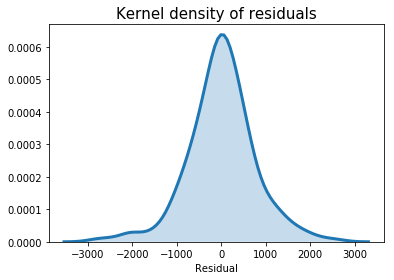

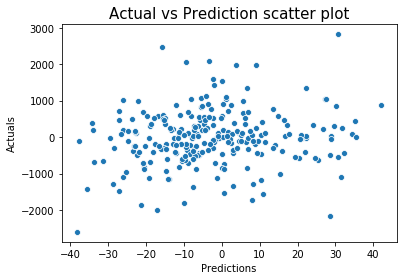

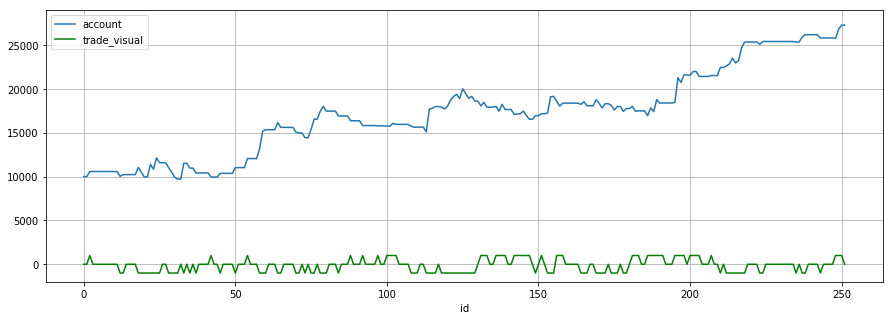

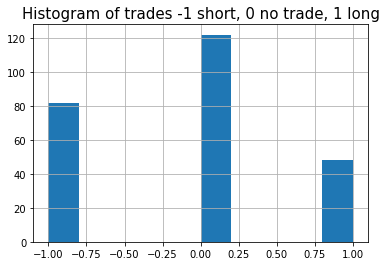

In [95]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_nn_reg')

In [96]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1928 samples, validate on 483 samples
Epoch 1/1000
1928/1928 [==============================] - 2s 1ms/step - loss: 132372.6728 - val_loss: 131889.2787

Epoch 00001: val_loss improved from inf to 131889.27868, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1928/1928 [==============================] - 0s 163us/step - loss: 132370.7166 - val_loss: 131889.8147

Epoch 00002: val_loss did not improve from 131889.27868
Epoch 3/1000
1928/1928 [==============================] - 0s 149us/step - loss: 132360.0870 - val_loss: 131890.1088

Epoch 00003: val_loss did not improve from 131889.27868
Epoch 4/1000
1928/1928 [==============================] - 0s 156us/step - loss: 132362.4749 - val_loss: 131890.3302

Epoch 00004: val_loss did not improve from 131889.27868
Epoch 5/1000
1928/1928 [==============================] - 0s 155us/step - loss: 132357.5187 - val_loss: 131890.8487

Epoch 00005: val_loss did not improve from 131889.27868
Epoch 6/1000
1928/1928 [==============


Epoch 00047: val_loss did not improve from 131889.27868
Epoch 48/1000
1928/1928 [==============================] - 0s 147us/step - loss: 131166.5964 - val_loss: 131954.2153

Epoch 00048: val_loss did not improve from 131889.27868
Epoch 49/1000
1928/1928 [==============================] - 0s 156us/step - loss: 131173.8312 - val_loss: 131961.4668

Epoch 00049: val_loss did not improve from 131889.27868
Epoch 50/1000
1928/1928 [==============================] - 0s 169us/step - loss: 131089.2579 - val_loss: 131959.1137

Epoch 00050: val_loss did not improve from 131889.27868
Epoch 51/1000
1928/1928 [==============================] - 0s 178us/step - loss: 131038.5402 - val_loss: 131956.7101

Epoch 00051: val_loss did not improve from 131889.27868
Epoch 52/1000
1928/1928 [==============================] - 0s 163us/step - loss: 130972.0560 - val_loss: 131960.1196

Epoch 00052: val_loss did not improve from 131889.27868
Epoch 53/1000
1928/1928 [==============================] - 0s 149us/step 

1928/1928 [==============================] - 0s 143us/step - loss: 127466.1520 - val_loss: 132018.5985

Epoch 00095: val_loss did not improve from 131889.27868
Epoch 96/1000
1928/1928 [==============================] - 0s 141us/step - loss: 127358.1412 - val_loss: 132027.7228

Epoch 00096: val_loss did not improve from 131889.27868
Epoch 97/1000
1928/1928 [==============================] - 0s 145us/step - loss: 127126.3968 - val_loss: 132039.3553

Epoch 00097: val_loss did not improve from 131889.27868
Epoch 98/1000
1928/1928 [==============================] - 0s 143us/step - loss: 127087.4370 - val_loss: 132050.9219

Epoch 00098: val_loss did not improve from 131889.27868
Epoch 99/1000
1928/1928 [==============================] - 0s 139us/step - loss: 127143.8150 - val_loss: 132055.0033

Epoch 00099: val_loss did not improve from 131889.27868
Epoch 100/1000
1928/1928 [==============================] - 0s 141us/step - loss: 126927.0669 - val_loss: 132051.4330

Epoch 00100: val_loss did

1928/1928 [==============================] - 0s 141us/step - loss: 122280.9980 - val_loss: 132216.3262

Epoch 00142: val_loss did not improve from 131889.27868
Epoch 143/1000
1928/1928 [==============================] - 0s 139us/step - loss: 122592.7736 - val_loss: 132248.2588

Epoch 00143: val_loss did not improve from 131889.27868
Epoch 144/1000
1928/1928 [==============================] - 0s 148us/step - loss: 122574.3090 - val_loss: 132262.1952

Epoch 00144: val_loss did not improve from 131889.27868
Epoch 145/1000
1928/1928 [==============================] - 0s 145us/step - loss: 122111.5360 - val_loss: 132251.2876

Epoch 00145: val_loss did not improve from 131889.27868
Epoch 146/1000
1928/1928 [==============================] - 0s 146us/step - loss: 121919.0077 - val_loss: 132274.8263

Epoch 00146: val_loss did not improve from 131889.27868
Epoch 147/1000
1928/1928 [==============================] - 0s 153us/step - loss: 122085.4838 - val_loss: 132287.5847

Epoch 00147: val_loss

1928/1928 [==============================] - 0s 142us/step - loss: 117191.4655 - val_loss: 132667.7885

Epoch 00189: val_loss did not improve from 131889.27868
Epoch 190/1000
1928/1928 [==============================] - 0s 147us/step - loss: 116793.5155 - val_loss: 132712.2839

Epoch 00190: val_loss did not improve from 131889.27868
Epoch 191/1000
1928/1928 [==============================] - 0s 139us/step - loss: 117420.9040 - val_loss: 132733.3639

Epoch 00191: val_loss did not improve from 131889.27868
Epoch 192/1000
1928/1928 [==============================] - 0s 138us/step - loss: 116593.5681 - val_loss: 132694.4237

Epoch 00192: val_loss did not improve from 131889.27868
Epoch 193/1000
1928/1928 [==============================] - 0s 139us/step - loss: 116322.5082 - val_loss: 132669.1551

Epoch 00193: val_loss did not improve from 131889.27868
Epoch 194/1000
1928/1928 [==============================] - 0s 141us/step - loss: 116279.9065 - val_loss: 132666.2509

Epoch 00194: val_loss

1928/1928 [==============================] - 0s 143us/step - loss: 110804.8067 - val_loss: 133394.8710

Epoch 00236: val_loss did not improve from 131889.27868
Epoch 237/1000
1928/1928 [==============================] - 0s 149us/step - loss: 110330.7609 - val_loss: 133407.3412

Epoch 00237: val_loss did not improve from 131889.27868
Epoch 238/1000
1928/1928 [==============================] - 0s 143us/step - loss: 110346.1734 - val_loss: 133413.6389

Epoch 00238: val_loss did not improve from 131889.27868
Epoch 239/1000
1928/1928 [==============================] - 0s 169us/step - loss: 110330.1051 - val_loss: 133440.8653

Epoch 00239: val_loss did not improve from 131889.27868
Epoch 240/1000
1928/1928 [==============================] - 0s 149us/step - loss: 109946.7013 - val_loss: 133496.6163

Epoch 00240: val_loss did not improve from 131889.27868
Epoch 241/1000
1928/1928 [==============================] - 0s 147us/step - loss: 109805.5568 - val_loss: 133558.4300

Epoch 00241: val_loss

1928/1928 [==============================] - 0s 154us/step - loss: 103458.6947 - val_loss: 134261.3061

Epoch 00283: val_loss did not improve from 131889.27868
Epoch 284/1000
1928/1928 [==============================] - 0s 151us/step - loss: 103179.3485 - val_loss: 134255.0739

Epoch 00284: val_loss did not improve from 131889.27868
Epoch 285/1000
1928/1928 [==============================] - 0s 142us/step - loss: 103342.8194 - val_loss: 134293.7523

Epoch 00285: val_loss did not improve from 131889.27868
Epoch 286/1000
1928/1928 [==============================] - 0s 148us/step - loss: 103311.2392 - val_loss: 134322.6519

Epoch 00286: val_loss did not improve from 131889.27868
Epoch 287/1000
1928/1928 [==============================] - 0s 140us/step - loss: 103002.0227 - val_loss: 134325.2269

Epoch 00287: val_loss did not improve from 131889.27868
Epoch 288/1000
1928/1928 [==============================] - 0s 139us/step - loss: 102658.6918 - val_loss: 134269.0972

Epoch 00288: val_loss

1928/1928 [==============================] - 0s 143us/step - loss: 96704.5776 - val_loss: 135543.0982

Epoch 00330: val_loss did not improve from 131889.27868
Epoch 331/1000
1928/1928 [==============================] - 0s 140us/step - loss: 95673.1601 - val_loss: 135582.3776

Epoch 00331: val_loss did not improve from 131889.27868
Epoch 332/1000
1928/1928 [==============================] - 0s 141us/step - loss: 95570.8111 - val_loss: 135624.0000

Epoch 00332: val_loss did not improve from 131889.27868
Epoch 333/1000
1928/1928 [==============================] - 0s 155us/step - loss: 95004.8790 - val_loss: 135791.0769

Epoch 00333: val_loss did not improve from 131889.27868
Epoch 334/1000
1928/1928 [==============================] - 0s 151us/step - loss: 94871.4337 - val_loss: 135733.5449

Epoch 00334: val_loss did not improve from 131889.27868
Epoch 335/1000
1928/1928 [==============================] - 0s 138us/step - loss: 95608.0327 - val_loss: 135783.8407

Epoch 00335: val_loss did n

1928/1928 [==============================] - 0s 146us/step - loss: 88859.9012 - val_loss: 137625.3398

Epoch 00377: val_loss did not improve from 131889.27868
Epoch 378/1000
1928/1928 [==============================] - 0s 137us/step - loss: 89137.8832 - val_loss: 137735.5386

Epoch 00378: val_loss did not improve from 131889.27868
Epoch 379/1000
1928/1928 [==============================] - 0s 141us/step - loss: 88478.6811 - val_loss: 137788.4624

Epoch 00379: val_loss did not improve from 131889.27868
Epoch 380/1000
1928/1928 [==============================] - 0s 147us/step - loss: 87987.3980 - val_loss: 137749.6148

Epoch 00380: val_loss did not improve from 131889.27868
Epoch 381/1000
1928/1928 [==============================] - 0s 138us/step - loss: 87705.7184 - val_loss: 137684.5109

Epoch 00381: val_loss did not improve from 131889.27868
Epoch 382/1000
1928/1928 [==============================] - 0s 137us/step - loss: 87521.7833 - val_loss: 137641.0871

Epoch 00382: val_loss did n

1928/1928 [==============================] - 0s 137us/step - loss: 81826.5444 - val_loss: 139587.8663

Epoch 00424: val_loss did not improve from 131889.27868
Epoch 425/1000
1928/1928 [==============================] - 0s 143us/step - loss: 80727.5401 - val_loss: 139533.4665

Epoch 00425: val_loss did not improve from 131889.27868
Epoch 426/1000
1928/1928 [==============================] - 0s 138us/step - loss: 80068.6393 - val_loss: 139580.2705

Epoch 00426: val_loss did not improve from 131889.27868
Epoch 427/1000
1928/1928 [==============================] - 0s 140us/step - loss: 80347.5157 - val_loss: 139642.4507

Epoch 00427: val_loss did not improve from 131889.27868
Epoch 428/1000
1928/1928 [==============================] - 0s 143us/step - loss: 79497.8937 - val_loss: 139633.2742

Epoch 00428: val_loss did not improve from 131889.27868
Epoch 429/1000
1928/1928 [==============================] - 0s 139us/step - loss: 80847.4866 - val_loss: 139735.6963

Epoch 00429: val_loss did n

1928/1928 [==============================] - 0s 143us/step - loss: 72662.0495 - val_loss: 142037.7856

Epoch 00471: val_loss did not improve from 131889.27868
Epoch 472/1000
1928/1928 [==============================] - 0s 155us/step - loss: 71921.4626 - val_loss: 142294.6067

Epoch 00472: val_loss did not improve from 131889.27868
Epoch 473/1000
1928/1928 [==============================] - 0s 148us/step - loss: 72735.3339 - val_loss: 142392.6403

Epoch 00473: val_loss did not improve from 131889.27868
Epoch 474/1000
1928/1928 [==============================] - 0s 142us/step - loss: 72889.9664 - val_loss: 142540.5201

Epoch 00474: val_loss did not improve from 131889.27868
Epoch 475/1000
1928/1928 [==============================] - 0s 140us/step - loss: 72201.1176 - val_loss: 142494.7680

Epoch 00475: val_loss did not improve from 131889.27868
Epoch 476/1000
1928/1928 [==============================] - 0s 143us/step - loss: 72637.9337 - val_loss: 142410.1597

Epoch 00476: val_loss did n

1928/1928 [==============================] - 0s 138us/step - loss: 65909.9874 - val_loss: 145879.0269

Epoch 00518: val_loss did not improve from 131889.27868
Epoch 519/1000
1928/1928 [==============================] - 0s 138us/step - loss: 65163.8315 - val_loss: 145824.9397

Epoch 00519: val_loss did not improve from 131889.27868
Epoch 520/1000
1928/1928 [==============================] - 0s 164us/step - loss: 66534.7633 - val_loss: 145581.2973

Epoch 00520: val_loss did not improve from 131889.27868
Epoch 521/1000
1928/1928 [==============================] - 0s 137us/step - loss: 64897.7816 - val_loss: 145571.4520

Epoch 00521: val_loss did not improve from 131889.27868
Epoch 522/1000
1928/1928 [==============================] - 0s 141us/step - loss: 64809.8308 - val_loss: 145523.3183

Epoch 00522: val_loss did not improve from 131889.27868
Epoch 523/1000
1928/1928 [==============================] - 0s 148us/step - loss: 63554.0520 - val_loss: 145744.9457

Epoch 00523: val_loss did n

1928/1928 [==============================] - 0s 139us/step - loss: 58739.2213 - val_loss: 150145.8410

Epoch 00565: val_loss did not improve from 131889.27868
Epoch 566/1000
1928/1928 [==============================] - 0s 144us/step - loss: 58592.6416 - val_loss: 150047.8263

Epoch 00566: val_loss did not improve from 131889.27868
Epoch 567/1000
1928/1928 [==============================] - 0s 139us/step - loss: 57886.7053 - val_loss: 150088.6524

Epoch 00567: val_loss did not improve from 131889.27868
Epoch 568/1000
1928/1928 [==============================] - 0s 149us/step - loss: 58548.9219 - val_loss: 150794.4207

Epoch 00568: val_loss did not improve from 131889.27868
Epoch 569/1000
1928/1928 [==============================] - 0s 136us/step - loss: 57274.9376 - val_loss: 150604.4291

Epoch 00569: val_loss did not improve from 131889.27868
Epoch 570/1000
1928/1928 [==============================] - 0s 151us/step - loss: 57627.1454 - val_loss: 150823.2389

Epoch 00570: val_loss did n

1928/1928 [==============================] - 0s 136us/step - loss: 51581.8116 - val_loss: 154850.7246

Epoch 00612: val_loss did not improve from 131889.27868
Epoch 613/1000
1928/1928 [==============================] - 0s 133us/step - loss: 50198.4427 - val_loss: 154820.8361

Epoch 00613: val_loss did not improve from 131889.27868
Epoch 614/1000
1928/1928 [==============================] - 0s 136us/step - loss: 49911.5300 - val_loss: 155134.2158

Epoch 00614: val_loss did not improve from 131889.27868
Epoch 615/1000
1928/1928 [==============================] - 0s 137us/step - loss: 50288.0838 - val_loss: 154753.3709

Epoch 00615: val_loss did not improve from 131889.27868
Epoch 616/1000
1928/1928 [==============================] - 0s 132us/step - loss: 51575.9480 - val_loss: 155373.8046

Epoch 00616: val_loss did not improve from 131889.27868
Epoch 617/1000
1928/1928 [==============================] - 0s 135us/step - loss: 52357.0132 - val_loss: 155244.5603

Epoch 00617: val_loss did n

1928/1928 [==============================] - 0s 137us/step - loss: 46756.3797 - val_loss: 161495.7186

Epoch 00659: val_loss did not improve from 131889.27868
Epoch 660/1000
1928/1928 [==============================] - 0s 137us/step - loss: 44677.0397 - val_loss: 161744.6988

Epoch 00660: val_loss did not improve from 131889.27868
Epoch 661/1000
1928/1928 [==============================] - 0s 146us/step - loss: 43835.2943 - val_loss: 161698.7939

Epoch 00661: val_loss did not improve from 131889.27868
Epoch 662/1000
1928/1928 [==============================] - 0s 145us/step - loss: 45922.6359 - val_loss: 161729.6875

Epoch 00662: val_loss did not improve from 131889.27868
Epoch 663/1000
1928/1928 [==============================] - 0s 155us/step - loss: 44850.7994 - val_loss: 162581.3022

Epoch 00663: val_loss did not improve from 131889.27868
Epoch 664/1000
1928/1928 [==============================] - 0s 140us/step - loss: 43713.6661 - val_loss: 162285.9507

Epoch 00664: val_loss did n

1928/1928 [==============================] - 0s 139us/step - loss: 39310.2550 - val_loss: 166359.3657

Epoch 00706: val_loss did not improve from 131889.27868
Epoch 707/1000
1928/1928 [==============================] - 0s 134us/step - loss: 40619.7115 - val_loss: 167060.9033

Epoch 00707: val_loss did not improve from 131889.27868
Epoch 708/1000
1928/1928 [==============================] - 0s 136us/step - loss: 37995.7157 - val_loss: 167502.1190

Epoch 00708: val_loss did not improve from 131889.27868
Epoch 709/1000
1928/1928 [==============================] - 0s 151us/step - loss: 39777.9663 - val_loss: 167841.8745

Epoch 00709: val_loss did not improve from 131889.27868
Epoch 710/1000
1928/1928 [==============================] - 0s 155us/step - loss: 37766.7609 - val_loss: 167986.7220

Epoch 00710: val_loss did not improve from 131889.27868
Epoch 711/1000
1928/1928 [==============================] - 0s 155us/step - loss: 40004.8610 - val_loss: 167710.9728

Epoch 00711: val_loss did n

1928/1928 [==============================] - 0s 165us/step - loss: 33650.6455 - val_loss: 173664.6538

Epoch 00753: val_loss did not improve from 131889.27868
Epoch 754/1000
1928/1928 [==============================] - 0s 151us/step - loss: 36652.9107 - val_loss: 173762.6712

Epoch 00754: val_loss did not improve from 131889.27868
Epoch 755/1000
1928/1928 [==============================] - 0s 154us/step - loss: 34894.7823 - val_loss: 173194.5302

Epoch 00755: val_loss did not improve from 131889.27868
Epoch 756/1000
1928/1928 [==============================] - 0s 147us/step - loss: 36215.5536 - val_loss: 173827.3612

Epoch 00756: val_loss did not improve from 131889.27868
Epoch 757/1000
1928/1928 [==============================] - 0s 145us/step - loss: 34960.6343 - val_loss: 173717.6912

Epoch 00757: val_loss did not improve from 131889.27868
Epoch 758/1000
1928/1928 [==============================] - 0s 143us/step - loss: 34959.2469 - val_loss: 173474.0436

Epoch 00758: val_loss did n

1928/1928 [==============================] - 0s 146us/step - loss: 32907.1777 - val_loss: 179992.0806

Epoch 00800: val_loss did not improve from 131889.27868
Epoch 801/1000
1928/1928 [==============================] - 0s 141us/step - loss: 31656.6183 - val_loss: 180594.1257

Epoch 00801: val_loss did not improve from 131889.27868
Epoch 802/1000
1928/1928 [==============================] - 0s 144us/step - loss: 31516.0691 - val_loss: 180841.0723

Epoch 00802: val_loss did not improve from 131889.27868
Epoch 803/1000
1928/1928 [==============================] - 0s 145us/step - loss: 30048.2977 - val_loss: 181009.4892

Epoch 00803: val_loss did not improve from 131889.27868
Epoch 804/1000
1928/1928 [==============================] - 0s 141us/step - loss: 31056.4546 - val_loss: 180571.2024

Epoch 00804: val_loss did not improve from 131889.27868
Epoch 805/1000
1928/1928 [==============================] - 0s 140us/step - loss: 31468.6566 - val_loss: 180613.5714

Epoch 00805: val_loss did n

1928/1928 [==============================] - 0s 140us/step - loss: 28468.7066 - val_loss: 187543.4451

Epoch 00847: val_loss did not improve from 131889.27868
Epoch 848/1000
1928/1928 [==============================] - 0s 145us/step - loss: 27314.7242 - val_loss: 187918.2932

Epoch 00848: val_loss did not improve from 131889.27868
Epoch 849/1000
1928/1928 [==============================] - 0s 139us/step - loss: 28311.8710 - val_loss: 187062.5654

Epoch 00849: val_loss did not improve from 131889.27868
Epoch 850/1000
1928/1928 [==============================] - 0s 141us/step - loss: 27524.1483 - val_loss: 186295.3496

Epoch 00850: val_loss did not improve from 131889.27868
Epoch 851/1000
1928/1928 [==============================] - 0s 139us/step - loss: 28404.6430 - val_loss: 186442.7404

Epoch 00851: val_loss did not improve from 131889.27868
Epoch 852/1000
1928/1928 [==============================] - 0s 143us/step - loss: 27550.0998 - val_loss: 188850.8288

Epoch 00852: val_loss did n

1928/1928 [==============================] - 0s 138us/step - loss: 25384.3010 - val_loss: 192975.8401

Epoch 00894: val_loss did not improve from 131889.27868
Epoch 895/1000
1928/1928 [==============================] - 0s 140us/step - loss: 26258.7149 - val_loss: 192184.9731

Epoch 00895: val_loss did not improve from 131889.27868
Epoch 896/1000
1928/1928 [==============================] - 0s 140us/step - loss: 27483.3179 - val_loss: 191877.9461

Epoch 00896: val_loss did not improve from 131889.27868
Epoch 897/1000
1928/1928 [==============================] - 0s 153us/step - loss: 26879.8882 - val_loss: 191810.5013

Epoch 00897: val_loss did not improve from 131889.27868
Epoch 898/1000
1928/1928 [==============================] - 0s 173us/step - loss: 26096.1590 - val_loss: 193380.4424

Epoch 00898: val_loss did not improve from 131889.27868
Epoch 899/1000
1928/1928 [==============================] - 0s 142us/step - loss: 25285.4732 - val_loss: 193699.7076

Epoch 00899: val_loss did n

1928/1928 [==============================] - 0s 146us/step - loss: 24608.5856 - val_loss: 197259.0042

Epoch 00941: val_loss did not improve from 131889.27868
Epoch 942/1000
1928/1928 [==============================] - 0s 145us/step - loss: 24608.7508 - val_loss: 198051.9031

Epoch 00942: val_loss did not improve from 131889.27868
Epoch 943/1000
1928/1928 [==============================] - 0s 153us/step - loss: 23329.2315 - val_loss: 198460.6534

Epoch 00943: val_loss did not improve from 131889.27868
Epoch 944/1000
1928/1928 [==============================] - 0s 182us/step - loss: 25528.6112 - val_loss: 197742.2086

Epoch 00944: val_loss did not improve from 131889.27868
Epoch 945/1000
1928/1928 [==============================] - 0s 145us/step - loss: 24113.8608 - val_loss: 197078.9024

Epoch 00945: val_loss did not improve from 131889.27868
Epoch 946/1000
1928/1928 [==============================] - 0s 146us/step - loss: 24620.0711 - val_loss: 197256.4330

Epoch 00946: val_loss did n

1928/1928 [==============================] - 0s 169us/step - loss: 22570.1284 - val_loss: 200607.1864

Epoch 00988: val_loss did not improve from 131889.27868
Epoch 989/1000
1928/1928 [==============================] - 0s 218us/step - loss: 24141.2922 - val_loss: 201588.9113

Epoch 00989: val_loss did not improve from 131889.27868
Epoch 990/1000
1928/1928 [==============================] - 0s 139us/step - loss: 23516.4302 - val_loss: 201238.9529

Epoch 00990: val_loss did not improve from 131889.27868
Epoch 991/1000
1928/1928 [==============================] - 0s 140us/step - loss: 23831.6989 - val_loss: 202142.9985

Epoch 00991: val_loss did not improve from 131889.27868
Epoch 992/1000
1928/1928 [==============================] - 0s 151us/step - loss: 23967.2713 - val_loss: 203187.5709

Epoch 00992: val_loss did not improve from 131889.27868
Epoch 993/1000
1928/1928 [==============================] - 0s 152us/step - loss: 23452.7075 - val_loss: 203475.6783

Epoch 00993: val_loss did n

In [97]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.03467571684899475
Returns  -16.60 %
Number of trades:  40
Number of short trades:  0
Number of long trades:  40
Earnings per trade:  -41.51
Earnings per short trade:  0.00
Earnings per long trade:  -41.51
Precision score:  [0.         0.03301887 0.45      ]


/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


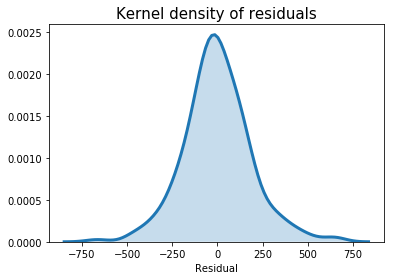

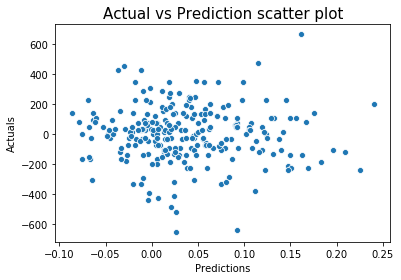

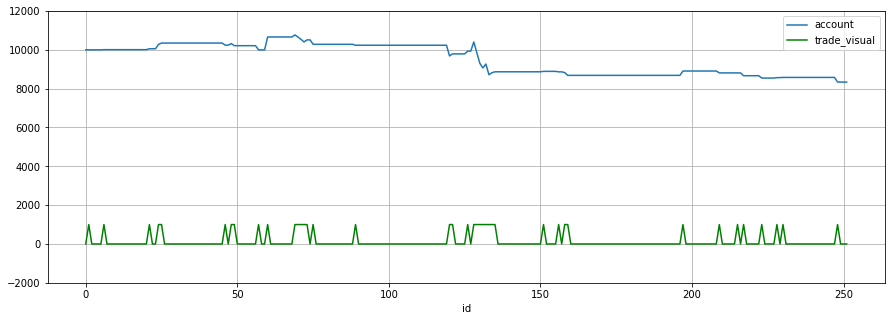

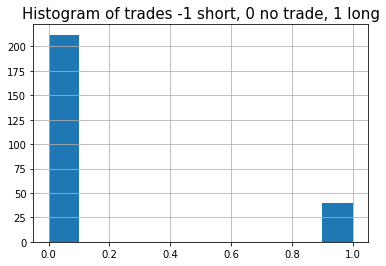

In [98]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.1, name='corn_nn_reg')

In [99]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 2s 1ms/step - loss: 133701.8877 - val_loss: 121253.1444

Epoch 00001: val_loss improved from inf to 121253.14437, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 167us/step - loss: 133692.5535 - val_loss: 121252.7380

Epoch 00002: val_loss improved from 121253.14437 to 121252.73802, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 3/1000
1922/1922 [==============================] - 0s 169us/step - loss: 133696.7741 - val_loss: 121252.9730

Epoch 00003: val_loss did not improve from 121252.73802
Epoch 4/1000
1922/1922 [==============================] - 0s 160us/step - loss: 133701.0361 - val_loss: 121252.8440

Epoch 00004: val_loss did not improve from 121252.73802
Epoch 5/1000
1922/1922 [==============================] - 0s 148us/step - loss: 133695.6586 - val_loss: 121252.6005

Epoch 00005: val_loss improve

1922/1922 [==============================] - 0s 143us/step - loss: 133024.5340 - val_loss: 121459.7143

Epoch 00046: val_loss did not improve from 121252.41103
Epoch 47/1000
1922/1922 [==============================] - 0s 145us/step - loss: 132974.9011 - val_loss: 121464.5276

Epoch 00047: val_loss did not improve from 121252.41103
Epoch 48/1000
1922/1922 [==============================] - 0s 143us/step - loss: 132980.2291 - val_loss: 121485.8418

Epoch 00048: val_loss did not improve from 121252.41103
Epoch 49/1000
1922/1922 [==============================] - 0s 147us/step - loss: 132948.8294 - val_loss: 121484.8856

Epoch 00049: val_loss did not improve from 121252.41103
Epoch 50/1000
1922/1922 [==============================] - 0s 147us/step - loss: 132881.7152 - val_loss: 121487.1985

Epoch 00050: val_loss did not improve from 121252.41103
Epoch 51/1000
1922/1922 [==============================] - 0s 149us/step - loss: 132875.3702 - val_loss: 121496.7384

Epoch 00051: val_loss did 

1922/1922 [==============================] - 0s 147us/step - loss: 130952.0799 - val_loss: 121710.7343

Epoch 00093: val_loss did not improve from 121252.41103
Epoch 94/1000
1922/1922 [==============================] - 0s 153us/step - loss: 130961.9121 - val_loss: 121710.8842

Epoch 00094: val_loss did not improve from 121252.41103
Epoch 95/1000
1922/1922 [==============================] - 0s 143us/step - loss: 130859.6326 - val_loss: 121736.7852

Epoch 00095: val_loss did not improve from 121252.41103
Epoch 96/1000
1922/1922 [==============================] - 0s 146us/step - loss: 130824.8080 - val_loss: 121735.1108

Epoch 00096: val_loss did not improve from 121252.41103
Epoch 97/1000
1922/1922 [==============================] - 0s 147us/step - loss: 131003.6302 - val_loss: 121753.8364

Epoch 00097: val_loss did not improve from 121252.41103
Epoch 98/1000
1922/1922 [==============================] - 0s 148us/step - loss: 130831.3668 - val_loss: 121773.4937

Epoch 00098: val_loss did 

1922/1922 [==============================] - 0s 183us/step - loss: 127532.0459 - val_loss: 121971.2090

Epoch 00140: val_loss did not improve from 121252.41103
Epoch 141/1000
1922/1922 [==============================] - 0s 159us/step - loss: 127618.6141 - val_loss: 121978.7596

Epoch 00141: val_loss did not improve from 121252.41103
Epoch 142/1000
1922/1922 [==============================] - 0s 146us/step - loss: 127370.3217 - val_loss: 121944.9799

Epoch 00142: val_loss did not improve from 121252.41103
Epoch 143/1000
1922/1922 [==============================] - 0s 147us/step - loss: 127017.5430 - val_loss: 121977.3710

Epoch 00143: val_loss did not improve from 121252.41103
Epoch 144/1000
1922/1922 [==============================] - 0s 149us/step - loss: 126856.6978 - val_loss: 121966.9433

Epoch 00144: val_loss did not improve from 121252.41103
Epoch 145/1000
1922/1922 [==============================] - 0s 155us/step - loss: 127357.3007 - val_loss: 121976.5632

Epoch 00145: val_loss

1922/1922 [==============================] - 0s 145us/step - loss: 122473.2390 - val_loss: 122380.6242

Epoch 00187: val_loss did not improve from 121252.41103
Epoch 188/1000
1922/1922 [==============================] - 0s 148us/step - loss: 122889.0237 - val_loss: 122399.8093

Epoch 00188: val_loss did not improve from 121252.41103
Epoch 189/1000
1922/1922 [==============================] - 0s 156us/step - loss: 122616.2740 - val_loss: 122417.9303

Epoch 00189: val_loss did not improve from 121252.41103
Epoch 190/1000
1922/1922 [==============================] - 0s 147us/step - loss: 123203.2420 - val_loss: 122409.7501

Epoch 00190: val_loss did not improve from 121252.41103
Epoch 191/1000
1922/1922 [==============================] - 0s 141us/step - loss: 122482.0329 - val_loss: 122439.7948

Epoch 00191: val_loss did not improve from 121252.41103
Epoch 192/1000
1922/1922 [==============================] - 0s 137us/step - loss: 122410.4727 - val_loss: 122465.5608

Epoch 00192: val_loss

1922/1922 [==============================] - 0s 228us/step - loss: 117860.3526 - val_loss: 122640.2338

Epoch 00234: val_loss did not improve from 121252.41103
Epoch 235/1000
1922/1922 [==============================] - 0s 191us/step - loss: 116666.1397 - val_loss: 122637.3958

Epoch 00235: val_loss did not improve from 121252.41103
Epoch 236/1000
1922/1922 [==============================] - 0s 163us/step - loss: 117032.8562 - val_loss: 122747.3637

Epoch 00236: val_loss did not improve from 121252.41103
Epoch 237/1000
1922/1922 [==============================] - 0s 167us/step - loss: 117370.6927 - val_loss: 122759.6438

Epoch 00237: val_loss did not improve from 121252.41103
Epoch 238/1000
1922/1922 [==============================] - 0s 166us/step - loss: 116815.8018 - val_loss: 122705.8661

Epoch 00238: val_loss did not improve from 121252.41103
Epoch 239/1000
1922/1922 [==============================] - 0s 149us/step - loss: 116871.0883 - val_loss: 122735.3025

Epoch 00239: val_loss

1922/1922 [==============================] - 0s 144us/step - loss: 111085.4227 - val_loss: 123534.2625

Epoch 00281: val_loss did not improve from 121252.41103
Epoch 282/1000
1922/1922 [==============================] - 0s 145us/step - loss: 109839.6710 - val_loss: 123495.1575

Epoch 00282: val_loss did not improve from 121252.41103
Epoch 283/1000
1922/1922 [==============================] - 0s 143us/step - loss: 109666.3165 - val_loss: 123421.5339

Epoch 00283: val_loss did not improve from 121252.41103
Epoch 284/1000
1922/1922 [==============================] - 0s 143us/step - loss: 110385.3854 - val_loss: 123483.5804

Epoch 00284: val_loss did not improve from 121252.41103
Epoch 285/1000
1922/1922 [==============================] - 0s 145us/step - loss: 109320.7730 - val_loss: 123462.7150

Epoch 00285: val_loss did not improve from 121252.41103
Epoch 286/1000
1922/1922 [==============================] - 0s 147us/step - loss: 111195.7913 - val_loss: 123576.6750

Epoch 00286: val_loss

1922/1922 [==============================] - 0s 137us/step - loss: 104347.7490 - val_loss: 124522.1155

Epoch 00328: val_loss did not improve from 121252.41103
Epoch 329/1000
1922/1922 [==============================] - 0s 136us/step - loss: 103007.0214 - val_loss: 124502.4383

Epoch 00329: val_loss did not improve from 121252.41103
Epoch 330/1000
1922/1922 [==============================] - 0s 137us/step - loss: 104198.8946 - val_loss: 124494.1332

Epoch 00330: val_loss did not improve from 121252.41103
Epoch 331/1000
1922/1922 [==============================] - 0s 140us/step - loss: 103878.1568 - val_loss: 124478.8947

Epoch 00331: val_loss did not improve from 121252.41103
Epoch 332/1000
1922/1922 [==============================] - 0s 139us/step - loss: 104103.6113 - val_loss: 124499.1526

Epoch 00332: val_loss did not improve from 121252.41103
Epoch 333/1000
1922/1922 [==============================] - 0s 139us/step - loss: 102722.8667 - val_loss: 124494.1243

Epoch 00333: val_loss

1922/1922 [==============================] - 0s 139us/step - loss: 97957.1495 - val_loss: 125841.9414

Epoch 00375: val_loss did not improve from 121252.41103
Epoch 376/1000
1922/1922 [==============================] - 0s 148us/step - loss: 96346.1272 - val_loss: 125842.8982

Epoch 00376: val_loss did not improve from 121252.41103
Epoch 377/1000
1922/1922 [==============================] - 0s 144us/step - loss: 96732.7717 - val_loss: 125837.2222

Epoch 00377: val_loss did not improve from 121252.41103
Epoch 378/1000
1922/1922 [==============================] - 0s 145us/step - loss: 96226.7608 - val_loss: 125878.1353

Epoch 00378: val_loss did not improve from 121252.41103
Epoch 379/1000
1922/1922 [==============================] - 0s 146us/step - loss: 96484.4419 - val_loss: 125861.8979

Epoch 00379: val_loss did not improve from 121252.41103
Epoch 380/1000
1922/1922 [==============================] - 0s 146us/step - loss: 96056.2986 - val_loss: 125995.6431

Epoch 00380: val_loss did n

1922/1922 [==============================] - 0s 158us/step - loss: 89298.9504 - val_loss: 127796.7395

Epoch 00422: val_loss did not improve from 121252.41103
Epoch 423/1000
1922/1922 [==============================] - 0s 149us/step - loss: 89081.7651 - val_loss: 127800.9364

Epoch 00423: val_loss did not improve from 121252.41103
Epoch 424/1000
1922/1922 [==============================] - 0s 145us/step - loss: 90497.6381 - val_loss: 127831.8452

Epoch 00424: val_loss did not improve from 121252.41103
Epoch 425/1000
1922/1922 [==============================] - 0s 147us/step - loss: 89004.5045 - val_loss: 127794.9024

Epoch 00425: val_loss did not improve from 121252.41103
Epoch 426/1000
1922/1922 [==============================] - 0s 144us/step - loss: 89747.4035 - val_loss: 127996.8281

Epoch 00426: val_loss did not improve from 121252.41103
Epoch 427/1000
1922/1922 [==============================] - 0s 134us/step - loss: 88904.0808 - val_loss: 128039.0820

Epoch 00427: val_loss did n

1922/1922 [==============================] - 0s 161us/step - loss: 82945.8019 - val_loss: 129548.9482

Epoch 00469: val_loss did not improve from 121252.41103
Epoch 470/1000
1922/1922 [==============================] - 0s 151us/step - loss: 81854.4059 - val_loss: 129723.2102

Epoch 00470: val_loss did not improve from 121252.41103
Epoch 471/1000
1922/1922 [==============================] - 0s 149us/step - loss: 81116.5694 - val_loss: 129902.5425

Epoch 00471: val_loss did not improve from 121252.41103
Epoch 472/1000
1922/1922 [==============================] - 0s 145us/step - loss: 80363.7901 - val_loss: 130129.6117

Epoch 00472: val_loss did not improve from 121252.41103
Epoch 473/1000
1922/1922 [==============================] - 0s 146us/step - loss: 81411.2109 - val_loss: 129952.5774

Epoch 00473: val_loss did not improve from 121252.41103
Epoch 474/1000
1922/1922 [==============================] - 0s 142us/step - loss: 81653.5002 - val_loss: 130080.8073

Epoch 00474: val_loss did n

1922/1922 [==============================] - 0s 144us/step - loss: 75275.1700 - val_loss: 133069.3477

Epoch 00516: val_loss did not improve from 121252.41103
Epoch 517/1000
1922/1922 [==============================] - 0s 162us/step - loss: 74076.5011 - val_loss: 132958.3518

Epoch 00517: val_loss did not improve from 121252.41103
Epoch 518/1000
1922/1922 [==============================] - 0s 150us/step - loss: 75083.4607 - val_loss: 133066.0201

Epoch 00518: val_loss did not improve from 121252.41103
Epoch 519/1000
1922/1922 [==============================] - 0s 159us/step - loss: 74036.3703 - val_loss: 132949.8143

Epoch 00519: val_loss did not improve from 121252.41103
Epoch 520/1000
1922/1922 [==============================] - 0s 153us/step - loss: 73258.2324 - val_loss: 133166.6743

Epoch 00520: val_loss did not improve from 121252.41103
Epoch 521/1000
1922/1922 [==============================] - 0s 183us/step - loss: 75447.3346 - val_loss: 133704.7395

Epoch 00521: val_loss did n

1922/1922 [==============================] - 0s 173us/step - loss: 68134.3163 - val_loss: 136038.4377

Epoch 00563: val_loss did not improve from 121252.41103
Epoch 564/1000
1922/1922 [==============================] - 0s 168us/step - loss: 66298.9498 - val_loss: 135461.0475

Epoch 00564: val_loss did not improve from 121252.41103
Epoch 565/1000
1922/1922 [==============================] - 0s 172us/step - loss: 65558.2740 - val_loss: 135514.8202

Epoch 00565: val_loss did not improve from 121252.41103
Epoch 566/1000
1922/1922 [==============================] - 0s 171us/step - loss: 67104.5911 - val_loss: 135768.0565

Epoch 00566: val_loss did not improve from 121252.41103
Epoch 567/1000
1922/1922 [==============================] - 0s 164us/step - loss: 67574.2139 - val_loss: 135946.4070

Epoch 00567: val_loss did not improve from 121252.41103
Epoch 568/1000
1922/1922 [==============================] - 0s 173us/step - loss: 67803.0309 - val_loss: 136502.3926

Epoch 00568: val_loss did n

1922/1922 [==============================] - 0s 150us/step - loss: 60115.0177 - val_loss: 139953.5923

Epoch 00610: val_loss did not improve from 121252.41103
Epoch 611/1000
1922/1922 [==============================] - 0s 148us/step - loss: 61511.2585 - val_loss: 139497.1485

Epoch 00611: val_loss did not improve from 121252.41103
Epoch 612/1000
1922/1922 [==============================] - 0s 152us/step - loss: 60261.5811 - val_loss: 139035.9813

Epoch 00612: val_loss did not improve from 121252.41103
Epoch 613/1000
1922/1922 [==============================] - 0s 149us/step - loss: 61247.5766 - val_loss: 139388.8868

Epoch 00613: val_loss did not improve from 121252.41103
Epoch 614/1000
1922/1922 [==============================] - 0s 149us/step - loss: 60159.8005 - val_loss: 139361.0364

Epoch 00614: val_loss did not improve from 121252.41103
Epoch 615/1000
1922/1922 [==============================] - 0s 158us/step - loss: 61395.3435 - val_loss: 139406.6274

Epoch 00615: val_loss did n

1922/1922 [==============================] - 0s 151us/step - loss: 54180.4678 - val_loss: 143923.7347

Epoch 00657: val_loss did not improve from 121252.41103
Epoch 658/1000
1922/1922 [==============================] - 0s 148us/step - loss: 55143.6737 - val_loss: 144330.5360

Epoch 00658: val_loss did not improve from 121252.41103
Epoch 659/1000
1922/1922 [==============================] - 0s 139us/step - loss: 54639.8827 - val_loss: 143760.1275

Epoch 00659: val_loss did not improve from 121252.41103
Epoch 660/1000
1922/1922 [==============================] - 0s 144us/step - loss: 54000.5107 - val_loss: 143807.2191

Epoch 00660: val_loss did not improve from 121252.41103
Epoch 661/1000
1922/1922 [==============================] - 0s 154us/step - loss: 52922.4176 - val_loss: 143986.2759

Epoch 00661: val_loss did not improve from 121252.41103
Epoch 662/1000
1922/1922 [==============================] - 0s 141us/step - loss: 54559.2695 - val_loss: 144317.7859

Epoch 00662: val_loss did n

1922/1922 [==============================] - 0s 162us/step - loss: 48534.2318 - val_loss: 148994.0146

Epoch 00704: val_loss did not improve from 121252.41103
Epoch 705/1000
1922/1922 [==============================] - 0s 163us/step - loss: 49366.0315 - val_loss: 149497.8055

Epoch 00705: val_loss did not improve from 121252.41103
Epoch 706/1000
1922/1922 [==============================] - 0s 150us/step - loss: 48366.8767 - val_loss: 149652.8862

Epoch 00706: val_loss did not improve from 121252.41103
Epoch 707/1000
1922/1922 [==============================] - 0s 158us/step - loss: 49026.2012 - val_loss: 150027.5281

Epoch 00707: val_loss did not improve from 121252.41103
Epoch 708/1000
1922/1922 [==============================] - 0s 148us/step - loss: 48022.6640 - val_loss: 149741.9220

Epoch 00708: val_loss did not improve from 121252.41103
Epoch 709/1000
1922/1922 [==============================] - 0s 158us/step - loss: 50106.5831 - val_loss: 149800.0035

Epoch 00709: val_loss did n

1922/1922 [==============================] - 0s 143us/step - loss: 44691.6980 - val_loss: 152861.4652

Epoch 00751: val_loss did not improve from 121252.41103
Epoch 752/1000
1922/1922 [==============================] - 0s 157us/step - loss: 44311.2458 - val_loss: 152665.8794

Epoch 00752: val_loss did not improve from 121252.41103
Epoch 753/1000
1922/1922 [==============================] - 0s 147us/step - loss: 41746.8041 - val_loss: 151806.4518

Epoch 00753: val_loss did not improve from 121252.41103
Epoch 754/1000
1922/1922 [==============================] - 0s 144us/step - loss: 42446.7112 - val_loss: 152689.4370

Epoch 00754: val_loss did not improve from 121252.41103
Epoch 755/1000
1922/1922 [==============================] - 0s 141us/step - loss: 43243.4647 - val_loss: 152345.3523

Epoch 00755: val_loss did not improve from 121252.41103
Epoch 756/1000
1922/1922 [==============================] - 0s 144us/step - loss: 42640.0891 - val_loss: 153552.8596

Epoch 00756: val_loss did n

1922/1922 [==============================] - 0s 158us/step - loss: 38545.7502 - val_loss: 159069.9189

Epoch 00798: val_loss did not improve from 121252.41103
Epoch 799/1000
1922/1922 [==============================] - 0s 148us/step - loss: 39678.4232 - val_loss: 158767.8133

Epoch 00799: val_loss did not improve from 121252.41103
Epoch 800/1000
1922/1922 [==============================] - 0s 149us/step - loss: 40176.3197 - val_loss: 158392.1915

Epoch 00800: val_loss did not improve from 121252.41103
Epoch 801/1000
1922/1922 [==============================] - 0s 148us/step - loss: 40048.6046 - val_loss: 158755.7926

Epoch 00801: val_loss did not improve from 121252.41103
Epoch 802/1000
1922/1922 [==============================] - 0s 146us/step - loss: 38620.6671 - val_loss: 159712.1773

Epoch 00802: val_loss did not improve from 121252.41103
Epoch 803/1000
1922/1922 [==============================] - 0s 154us/step - loss: 39449.7595 - val_loss: 159761.5858

Epoch 00803: val_loss did n

1922/1922 [==============================] - 0s 160us/step - loss: 37426.6512 - val_loss: 161975.7950

Epoch 00845: val_loss did not improve from 121252.41103
Epoch 846/1000
1922/1922 [==============================] - 0s 139us/step - loss: 35089.6036 - val_loss: 163177.2528

Epoch 00846: val_loss did not improve from 121252.41103
Epoch 847/1000
1922/1922 [==============================] - 0s 148us/step - loss: 37552.7240 - val_loss: 164283.2910

Epoch 00847: val_loss did not improve from 121252.41103
Epoch 848/1000
1922/1922 [==============================] - 0s 144us/step - loss: 36299.2566 - val_loss: 163256.3782

Epoch 00848: val_loss did not improve from 121252.41103
Epoch 849/1000
1922/1922 [==============================] - 0s 142us/step - loss: 37234.2651 - val_loss: 163537.4107

Epoch 00849: val_loss did not improve from 121252.41103
Epoch 850/1000
1922/1922 [==============================] - 0s 145us/step - loss: 35506.7721 - val_loss: 163789.8481

Epoch 00850: val_loss did n

1922/1922 [==============================] - 0s 166us/step - loss: 34082.8320 - val_loss: 171610.1064

Epoch 00892: val_loss did not improve from 121252.41103
Epoch 893/1000
1922/1922 [==============================] - 0s 151us/step - loss: 34544.4509 - val_loss: 171015.8015

Epoch 00893: val_loss did not improve from 121252.41103
Epoch 894/1000
1922/1922 [==============================] - 0s 168us/step - loss: 32478.8911 - val_loss: 170620.3120

Epoch 00894: val_loss did not improve from 121252.41103
Epoch 895/1000
1922/1922 [==============================] - 0s 155us/step - loss: 34815.8393 - val_loss: 170442.3407

Epoch 00895: val_loss did not improve from 121252.41103
Epoch 896/1000
1922/1922 [==============================] - 0s 144us/step - loss: 32059.0393 - val_loss: 169633.7449

Epoch 00896: val_loss did not improve from 121252.41103
Epoch 897/1000
1922/1922 [==============================] - 0s 146us/step - loss: 34198.5655 - val_loss: 169608.2323

Epoch 00897: val_loss did n

1922/1922 [==============================] - 0s 151us/step - loss: 31988.8003 - val_loss: 176950.4605

Epoch 00939: val_loss did not improve from 121252.41103
Epoch 940/1000
1922/1922 [==============================] - 0s 158us/step - loss: 31999.5235 - val_loss: 175681.2023

Epoch 00940: val_loss did not improve from 121252.41103
Epoch 941/1000
1922/1922 [==============================] - 0s 175us/step - loss: 32433.7591 - val_loss: 175236.7068

Epoch 00941: val_loss did not improve from 121252.41103
Epoch 942/1000
1922/1922 [==============================] - 0s 171us/step - loss: 30696.9125 - val_loss: 175608.4892

Epoch 00942: val_loss did not improve from 121252.41103
Epoch 943/1000
1922/1922 [==============================] - 0s 161us/step - loss: 31863.8888 - val_loss: 174607.8451

Epoch 00943: val_loss did not improve from 121252.41103
Epoch 944/1000
1922/1922 [==============================] - 0s 145us/step - loss: 31621.1390 - val_loss: 174685.3223

Epoch 00944: val_loss did n

1922/1922 [==============================] - 0s 145us/step - loss: 30895.1803 - val_loss: 177863.7153

Epoch 00986: val_loss did not improve from 121252.41103
Epoch 987/1000
1922/1922 [==============================] - 0s 147us/step - loss: 30545.7564 - val_loss: 178012.2771

Epoch 00987: val_loss did not improve from 121252.41103
Epoch 988/1000
1922/1922 [==============================] - 0s 152us/step - loss: 31964.8136 - val_loss: 177300.9058

Epoch 00988: val_loss did not improve from 121252.41103
Epoch 989/1000
1922/1922 [==============================] - 0s 155us/step - loss: 27677.5883 - val_loss: 176881.8997

Epoch 00989: val_loss did not improve from 121252.41103
Epoch 990/1000
1922/1922 [==============================] - 0s 147us/step - loss: 28400.6872 - val_loss: 176820.5590

Epoch 00990: val_loss did not improve from 121252.41103
Epoch 991/1000
1922/1922 [==============================] - 0s 148us/step - loss: 31483.8195 - val_loss: 177984.9272

Epoch 00991: val_loss did n

In [100]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.03891842351631789
Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00
Precision score:  [0.         0.03571429 0.        ]


/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


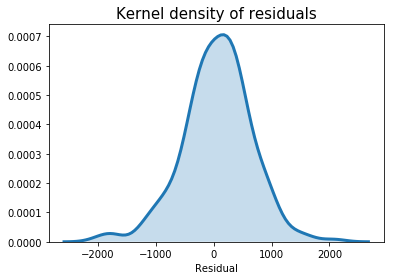

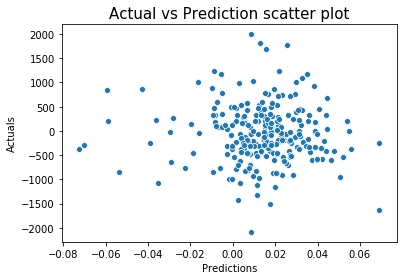

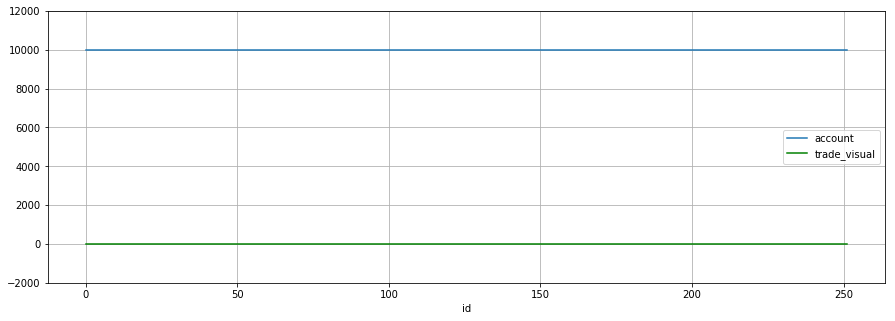

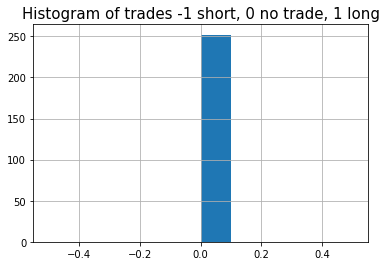

In [101]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1, name='coffee_nn_reg')

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [102]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv1mc08es
  JVM stdout: /tmp/tmpv1mc08es/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmpv1mc08es/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_martin_ecu5e9
H2O cluster total nodes:,1
H2O cluster free memory:,3.918 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190208_162419_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
XRT_1_AutoML_20190208_162419,0.477046,0.69162,0.5,0.476521,0.227073
StackedEnsemble_AllModels_AutoML_20190208_162419,0.476126,0.60746,0.5,0.456459,0.208355
StackedEnsemble_BestOfFamily_AutoML_20190208_162419,0.476126,0.60746,0.5,0.456459,0.208355
DRF_1_AutoML_20190208_162419,0.472127,0.650638,0.494616,0.474203,0.224868


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb98053eb38>]],
      dtype=object)

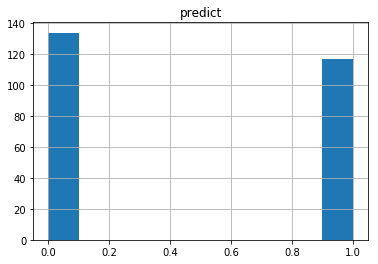

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [ ]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_long_automl_clf')

### H2O AutoML gold regressor

In [106]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190208_162545_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_BestOfFamily_AutoML_20190208_162545,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_AllModels_AutoML_20190208_162545,1.68533e+06,1298.2,1.68533e+06,896.418,nan
XRT_1_AutoML_20190208_162545,1.8717e+06,1368.1,1.8717e+06,965.536,nan
DRF_1_AutoML_20190208_162545,1.91745e+06,1384.72,1.91745e+06,975.795,nan


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9801b4198>]],
      dtype=object)

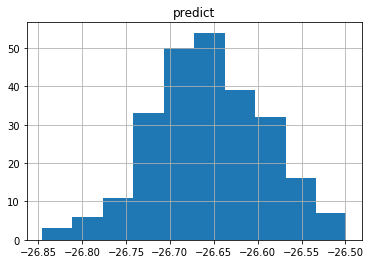

In [107]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [108]:
b

array([-26.64229968, -26.71641999, -26.708649  , -26.71515188,
       -26.63658053, -26.64446274, -26.64020086, -26.71253869,
       -26.66806547, -26.6756639 , -26.65211953, -26.64890615,
       -26.65344326, -26.61857664, -26.56154821, -26.57349536,
       -26.59273975, -26.64060133, -26.63128295, -26.66378233,
       -26.69216267, -26.72992689, -26.71783875, -26.6885868 ,
       -26.61967933, -26.58579422, -26.63610436, -26.69308651,
       -26.7082924 , -26.64246799, -26.54135393, -26.54918815,
       -26.64174458, -26.72843558, -26.78074026, -26.69889125,
       -26.73783544, -26.65964022, -26.65177147, -26.68606529,
       -26.67097812, -26.69366353, -26.6849714 , -26.6581517 ,
       -26.5768978 , -26.57849511, -26.66287907, -26.70672685,
       -26.70472282, -26.69631531, -26.64723116, -26.68017371,
       -26.64785677, -26.59564131, -26.63087327, -26.58388114,
       -26.62635637, -26.76022761, -26.7412088 , -26.68790975,
       -26.69833714, -26.70706475, -26.68660787, -26.66

In [109]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [110]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


ValueError: Classification metrics can't handle a mix of binary and continuous targets

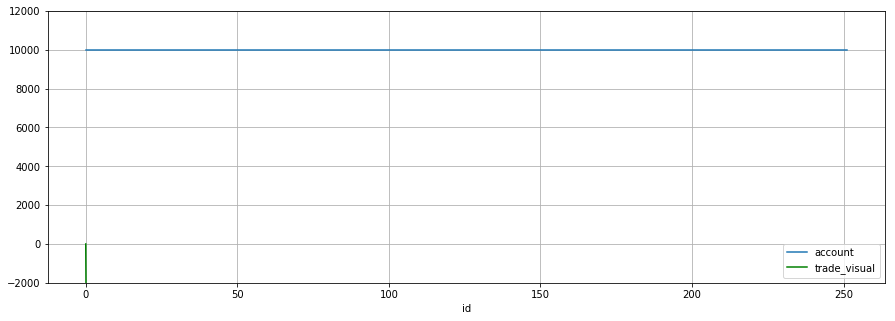

In [111]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True,  name='gold_automl_reg')

### H2O short trade

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

In [ ]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800,  name='gold_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

In [ ]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_automl_short_clf')

In [118]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190207_161659,0.545483,0.631149,0.486863,0.466671,0.217782
StackedEnsemble_BestOfFamily_AutoML_20190207_161659,0.542098,0.613183,0.480375,0.459596,0.211229
GBM_4_AutoML_20190207_161659,0.53766,0.651727,0.498509,0.47314,0.223861
DeepLearning_grid_1_AutoML_20190207_161659_model_1,0.533907,2.06138,0.5,0.570499,0.325469
GBM_5_AutoML_20190207_161659,0.532961,0.623489,0.499627,0.464026,0.21532
StackedEnsemble_AllModels_AutoML_20190207_161659,0.530244,0.614126,0.485388,0.46001,0.21161
GBM_grid_1_AutoML_20190207_161659_model_5,0.528271,0.61419,0.473213,0.460061,0.211656
GBM_grid_1_AutoML_20190207_161659_model_3,0.525618,0.614071,0.475957,0.459999,0.211599
GBM_grid_1_AutoML_20190207_161659_model_1,0.523735,0.614736,0.499254,0.460275,0.211853
XRT_1_AutoML_20190207_161659,0.521799,0.642431,0.495296,0.47096,0.221803


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb561257f98>]],
      dtype=object)

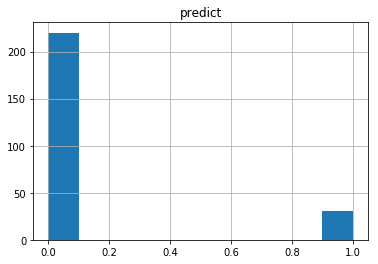

In [119]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [ ]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, , name='corn_automl_long_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [ ]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

In [ ]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [ ]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [ ]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

In [ ]:
nasdaq_amount

In [ ]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [ ]:
gold_mean.head()

In [ ]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)
savefig('figures/corn_benchmark_performance.eps')

In [ ]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)
savefig('figures/coffee_benchmark_performance.eps')

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.